In [9]:
# IPL Cricket Data Analysis
# Comprehensive analysis of IPL cricket data including team performance, player statistics, and player clustering


In [10]:

# ------------------ SECTION 1: SETUP AND IMPORTS ------------------

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import jinja2
import os
import warnings


In [11]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.cluster import KMeans


In [12]:

# Suppress warnings
warnings.filterwarnings('ignore')


In [13]:

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('bright')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [14]:

# ------------------ SECTION 2: DATA LOADING AND PREPROCESSING ------------------

# 2.1 Data Loading
print("Loading IPL datasets...")
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

print(f"Matches dataset shape: {matches.shape}")
print(f"Deliveries dataset shape: {deliveries.shape}")

# Display sample data
print("\nSample data from matches dataset:")
matches.head()


Loading IPL datasets...
Matches dataset shape: (1095, 20)
Deliveries dataset shape: (260920, 17)

Sample data from matches dataset:


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [15]:

# 2.2 Data Cleaning and Preprocessing
print("\nChecking for missing values in matches dataset:")
print(matches.isnull().sum())

# Handle missing values
matches['city'].fillna('Unknown', inplace=True)
matches['player_of_match'].fillna('Unknown', inplace=True)
matches['winner'].fillna('No Result', inplace=True)
matches['result_margin'].fillna(0, inplace=True)



Checking for missing values in matches dataset:
id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64


In [16]:

# Standardize team names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Rising Pune Supergiants': 'Rising Pune Supergiant',
    'Kings XI Punjab': 'Punjab Kings'
}

# Apply team name standardization
for old_name, new_name in team_name_mapping.items():
    matches['team1'] = matches['team1'].replace(old_name, new_name)
    matches['team2'] = matches['team2'].replace(old_name, new_name)
    matches['toss_winner'] = matches['toss_winner'].replace(old_name, new_name)
    matches['winner'] = matches['winner'].replace(old_name, new_name)
    
    deliveries['batting_team'] = deliveries['batting_team'].replace(old_name, new_name)
    deliveries['bowling_team'] = deliveries['bowling_team'].replace(old_name, new_name)

print("\nAfter cleaning, missing values in matches dataset:")
print(matches.isnull().sum())



After cleaning, missing values in matches dataset:
id                    0
season                0
city                  0
date                  0
match_type            0
player_of_match       0
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                0
result                0
result_margin         0
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64


In [17]:

# Ensure season column exists
if 'season' not in matches.columns:
    matches['season'] = pd.to_datetime(matches['date']).dt.year

# ------------------ SECTION 3: TEAM PERFORMANCE ANALYSIS ------------------

print("\n" + "="*30 + " TEAM PERFORMANCE ANALYSIS " + "="*30)

# 3.1 Matches played and won by each team
# Matches played by each team
team1_counts = matches['team1'].value_counts()
team2_counts = matches['team2'].value_counts()
team_matches = team1_counts.add(team2_counts, fill_value=0).astype(int)

# Matches won by each team
team_wins = matches['winner'].value_counts()

# Create a dataframe for team performance
team_performance = pd.DataFrame({
    'Matches_Played': team_matches,
    'Matches_Won': team_wins
})

team_performance['Win_Percentage'] = round((team_performance['Matches_Won'] / team_performance['Matches_Played']) * 100, 2)
team_performance = team_performance.sort_values('Win_Percentage', ascending=False)

print("\nTeam Performance (Win Percentage):")
print(team_performance)



============================== TEAM PERFORMANCE ANALYSIS ==============================

Team Performance (Win Percentage):
                             Matches_Played  Matches_Won  Win_Percentage
Gujarat Titans                         45.0           28           62.22
Chennai Super Kings                   238.0          138           57.98
Mumbai Indians                        261.0          144           55.17
Lucknow Super Giants                   44.0           24           54.55
Kolkata Knight Riders                 251.0          131           52.19
Rajasthan Royals                      221.0          112           50.68
Rising Pune Supergiant                 30.0           15           50.00
Royal Challengers Bangalore           240.0          116           48.33
Royal Challengers Bengaluru            15.0            7           46.67
Delhi Capitals                        252.0          115           45.63
Punjab Kings                          246.0          112           45.53

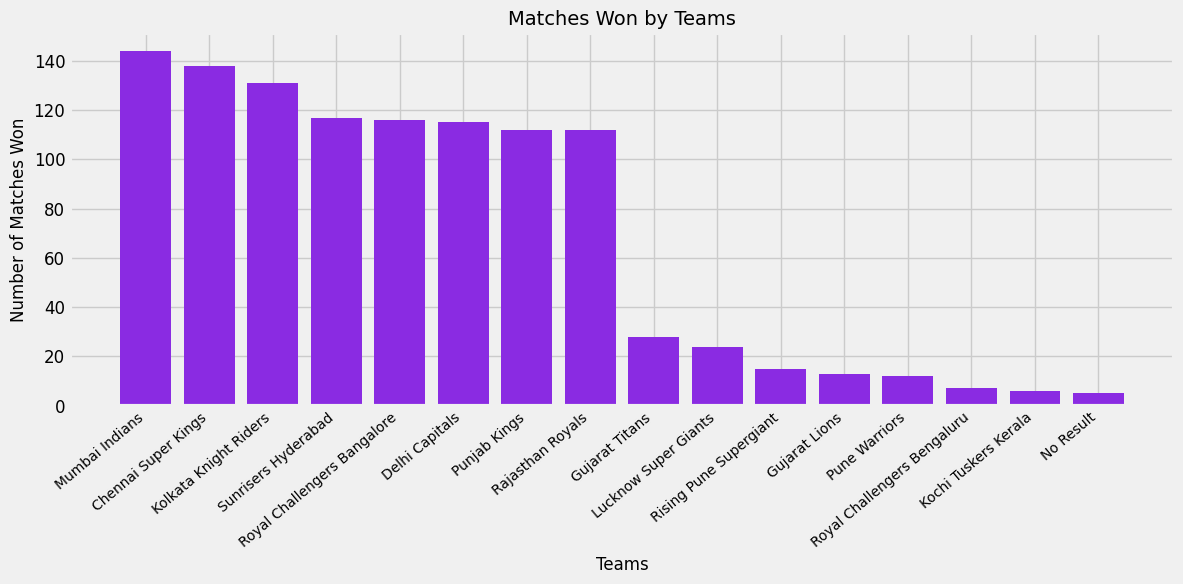

In [18]:

# Plot matches won by teams
plt.figure(figsize=(12, 6))
plt.bar(team_wins.index, team_wins.values, color='blueviolet')
plt.title('Matches Won by Teams', fontsize=14)
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Number of Matches Won', fontsize=12)
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('matches_won_by_teams.png')
plt.show()


In [19]:

# 3.2 Team Run Rates and Economy Rates
# Calculate run rates and economy rates
team_runs = {}
team_balls_faced = {}
team_runs_conceded = {}
team_balls_bowled = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    bowling_team = row['bowling_team']
    runs = row['total_runs']
    
    # Update batting stats
    if batting_team not in team_runs:
        team_runs[batting_team] = 0
        team_balls_faced[batting_team] = 0
    
    team_runs[batting_team] += runs
    team_balls_faced[batting_team] += 1
    
    # Update bowling stats
    if bowling_team not in team_runs_conceded:
        team_runs_conceded[bowling_team] = 0
        team_balls_bowled[bowling_team] = 0
    
    team_runs_conceded[bowling_team] += runs
    team_balls_bowled[bowling_team] += 1
    
# Calculate run rate and economy rate
teams_union = sorted(set(team_runs.keys()).union(set(team_runs_conceded.keys())))
team_stats = pd.DataFrame(index=teams_union)

team_stats['Run_Rate'] = pd.Series({
    team: (runs * 6 / team_balls_faced[team]) if team in team_balls_faced and team_balls_faced[team] else 0
    for team, runs in team_runs.items()
}).round(2)

team_stats['Economy_Rate'] = pd.Series({
    team: (runs * 6 / team_balls_bowled[team]) if team in team_balls_bowled and team_balls_bowled[team] else 0
    for team, runs in team_runs_conceded.items()
}).round(2)

print("\nTeam Run Rates and Economy Rates:")
print(team_stats)



Team Run Rates and Economy Rates:
                             Run_Rate  Economy_Rate
Chennai Super Kings              8.09          7.81
Delhi Capitals                   7.91          8.04
Gujarat Lions                    8.18          8.61
Gujarat Titans                   8.47          8.46
Kochi Tuskers Kerala             7.21          7.38
Kolkata Knight Riders            8.00          7.91
Lucknow Super Giants             8.34          8.51
Mumbai Indians                   8.05          7.86
Pune Warriors                    7.01          7.54
Punjab Kings                     8.06          8.22
Rajasthan Royals                 7.94          7.98
Rising Pune Supergiant           7.82          7.70
Royal Challengers Bangalore      8.02          8.04
Royal Challengers Bengaluru      9.67          9.39
Sunrisers Hyderabad              7.88          7.94


<Figure size 1200x700 with 0 Axes>

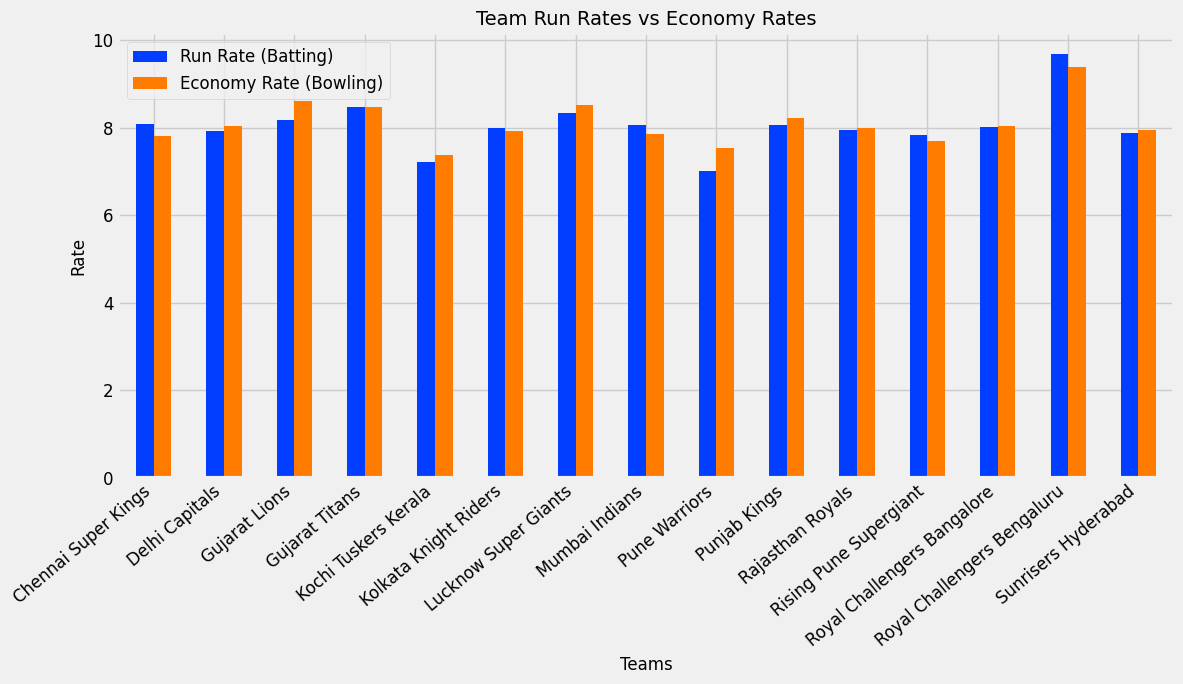

In [20]:

# Plot run rates and economy rates
plt.figure(figsize=(12, 7))
team_stats.plot(kind='bar', figsize=(12, 7))
plt.title('Team Run Rates vs Economy Rates', fontsize=14)
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.xticks(rotation=40, ha='right')
plt.legend(['Run Rate (Batting)', 'Economy Rate (Bowling)'])
plt.tight_layout()
plt.savefig('team_run_rates_economy.png')
plt.show()


In [21]:

# 3.3 Team Highest and Lowest Scores
# Calculate highest and lowest scores for each team
team_highest_scores = {}
team_lowest_scores = {}

for match_id in matches['id'].unique():
    match_deliveries = deliveries[deliveries['match_id'] == match_id]
    batting_teams = match_deliveries['batting_team'].unique()
    
    for team in batting_teams:
        team_deliveries = match_deliveries[match_deliveries['batting_team'] == team]
        total_score = team_deliveries['total_runs'].sum()
        
        if team not in team_highest_scores or total_score > team_highest_scores[team]:
            team_highest_scores[team] = total_score
            
        if team not in team_lowest_scores or total_score < team_lowest_scores[team]:
            team_lowest_scores[team] = total_score

# Create dataframe for highest and lowest scores
team_scores = pd.DataFrame({
    'Highest_Score': pd.Series(team_highest_scores),
    'Lowest_Score': pd.Series(team_lowest_scores)
})

print("\nTeam Highest and Lowest Scores:")
print(team_scores)



Team Highest and Lowest Scores:
                             Highest_Score  Lowest_Score
Kolkata Knight Riders                  272            48
Royal Challengers Bangalore            263             2
Chennai Super Kings                    246            55
Punjab Kings                           262            68
Rajasthan Royals                       226            41
Delhi Capitals                         257            56
Mumbai Indians                         247            68
Sunrisers Hyderabad                    287            44
Kochi Tuskers Kerala                   184            74
Pune Warriors                          192            99
Rising Pune Supergiant                 195            76
Gujarat Lions                          208           104
Lucknow Super Giants                   257            82
Gujarat Titans                         233            89
Royal Challengers Bengaluru            262           152


<Figure size 1200x600 with 0 Axes>

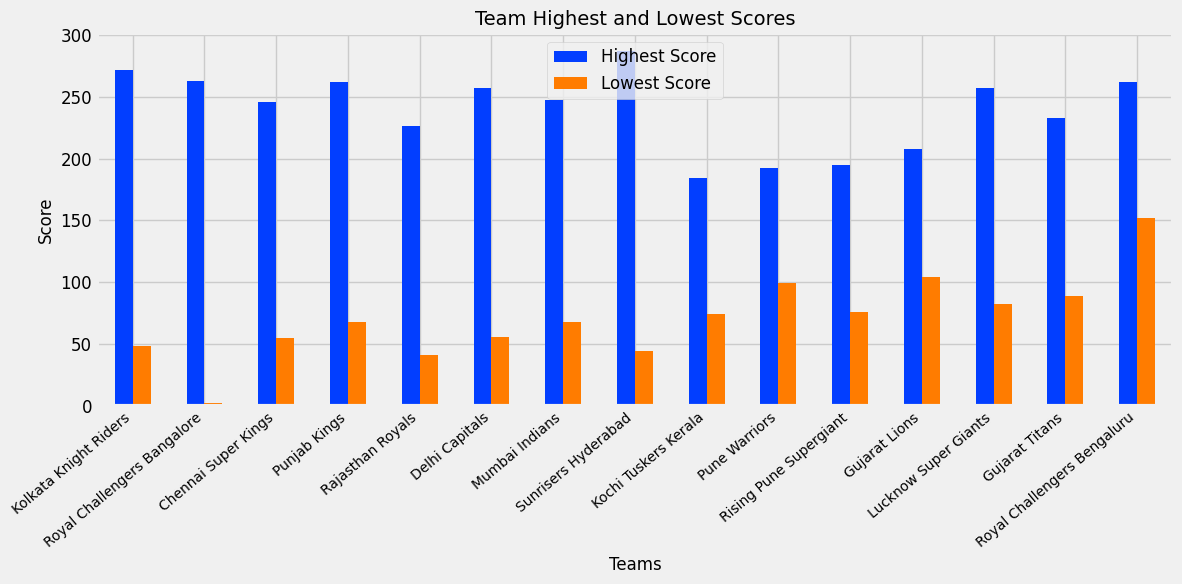

In [22]:

# Plot highest and lowest scores
plt.figure(figsize=(12, 6))
team_scores.plot(kind='bar', figsize=(12, 6))
plt.title('Team Highest and Lowest Scores', fontsize=14)
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.legend(['Highest Score', 'Lowest Score'])
plt.tight_layout()
plt.savefig('team_highest_lowest_scores.png')
plt.show()


In [23]:

# 3.4 Team Boundaries (4s and 6s)
# Calculate total 4s and 6s for each team
team_fours = {}
team_sixes = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    runs = row['batsman_runs']
    
    if batting_team not in team_fours:
        team_fours[batting_team] = 0
        team_sixes[batting_team] = 0
    
    if runs == 4:
        team_fours[batting_team] += 1
    elif runs == 6:
        team_sixes[batting_team] += 1

# Create dataframe for 4s and 6s
team_boundaries = pd.DataFrame({
    'Fours': pd.Series(team_fours),
    'Sixes': pd.Series(team_sixes)
})

print("\nTeam Boundaries (4s and 6s):")
print(team_boundaries)



Team Boundaries (4s and 6s):
                             Fours  Sixes
Kolkata Knight Riders         3461   1495
Royal Challengers Bangalore   3149   1488
Chennai Super Kings           3196   1509
Punjab Kings                  3426   1515
Rajasthan Royals              3091   1237
Delhi Capitals                3508   1351
Mumbai Indians                3637   1685
Sunrisers Hyderabad           3362   1442
Kochi Tuskers Kerala           170     53
Pune Warriors                  525    196
Rising Pune Supergiant         368    157
Gujarat Lions                  460    155
Lucknow Super Giants           577    332
Gujarat Titans                 691    271
Royal Challengers Bengaluru    229    165


<Figure size 1200x600 with 0 Axes>

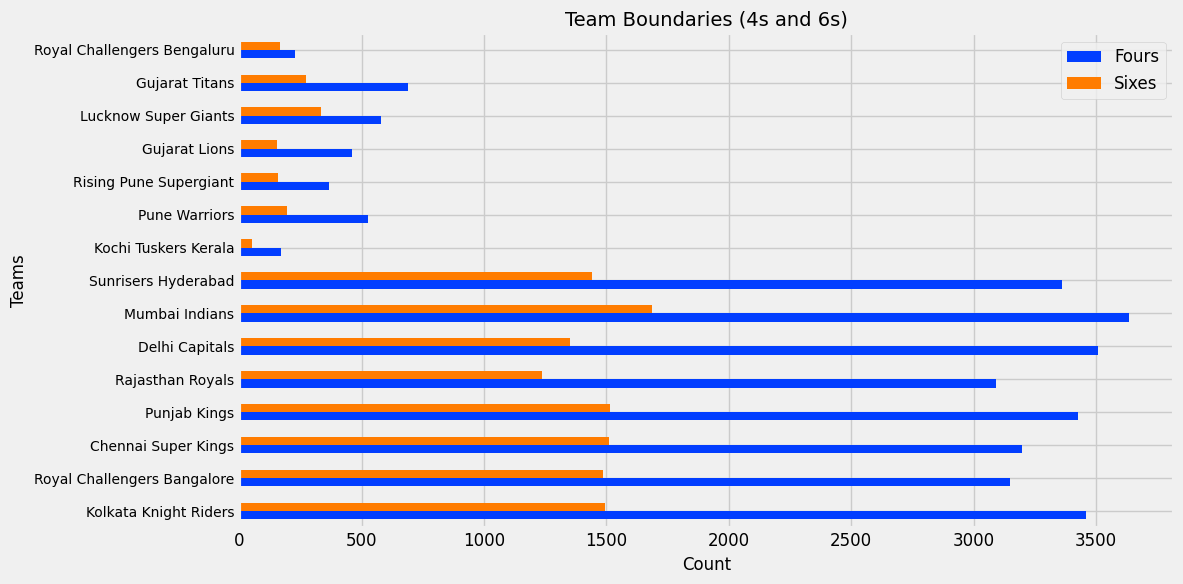

In [24]:

# Plot 4s and 6s
plt.figure(figsize=(12, 6))
team_boundaries.plot(kind='barh', figsize=(12, 6))
plt.title('Team Boundaries (4s and 6s)', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Teams', fontsize=12)
plt.yticks(fontsize=10)
plt.legend(['Fours', 'Sixes'])
plt.tight_layout()
plt.savefig('team_boundaries.png')
plt.show()


In [25]:

# 3.5 Powerplay and Death Overs Analysis
# Calculate powerplay and death overs scores
def is_powerplay(over):
    return over <= 6

def is_death_over(over):
    return over >= 16

team_powerplay_runs = {}
team_powerplay_balls = {}
team_death_runs = {}
team_death_balls = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    over = row['over']
    runs = row['total_runs']
    
    if batting_team not in team_powerplay_runs:
        team_powerplay_runs[batting_team] = 0
        team_powerplay_balls[batting_team] = 0
        team_death_runs[batting_team] = 0
        team_death_balls[batting_team] = 0
    
    if is_powerplay(over):
        team_powerplay_runs[batting_team] += runs
        team_powerplay_balls[batting_team] += 1
    
    if is_death_over(over):
        team_death_runs[batting_team] += runs
        team_death_balls[batting_team] += 1

# Calculate average powerplay and death overs score
team_phase_scores = pd.DataFrame(index=team_powerplay_runs.keys())
team_phase_scores['Avg_Powerplay_Score'] = pd.Series({team: (runs * 36 / balls) if balls > 0 else 0 
                                                    for team, runs, balls in zip(team_powerplay_runs.keys(), 
                                                                                team_powerplay_runs.values(), 
                                                                                team_powerplay_balls.values())}).round(2)
team_phase_scores['Avg_Death_Score'] = pd.Series({team: (runs * 30 / balls) if balls > 0 else 0 
                                                for team, runs, balls in zip(team_death_runs.keys(), 
                                                                            team_death_runs.values(), 
                                                                            team_death_balls.values())}).round(2)

print("\nTeam Average Powerplay and Death Overs Score:")
print(team_phase_scores)



Team Average Powerplay and Death Overs Score:
                             Avg_Powerplay_Score  Avg_Death_Score
Kolkata Knight Riders                      44.73            48.08
Royal Challengers Bangalore                43.00            50.91
Chennai Super Kings                        44.10            51.34
Punjab Kings                               45.30            46.71
Rajasthan Royals                           44.35            47.07
Delhi Capitals                             45.48            47.88
Mumbai Indians                             43.84            50.40
Sunrisers Hyderabad                        45.12            46.58
Kochi Tuskers Kerala                       44.51            42.48
Pune Warriors                              39.36            40.52
Rising Pune Supergiant                     44.68            49.57
Gujarat Lions                              49.69            45.07
Lucknow Super Giants                       44.36            50.28
Gujarat Titans               

<Figure size 1200x700 with 0 Axes>

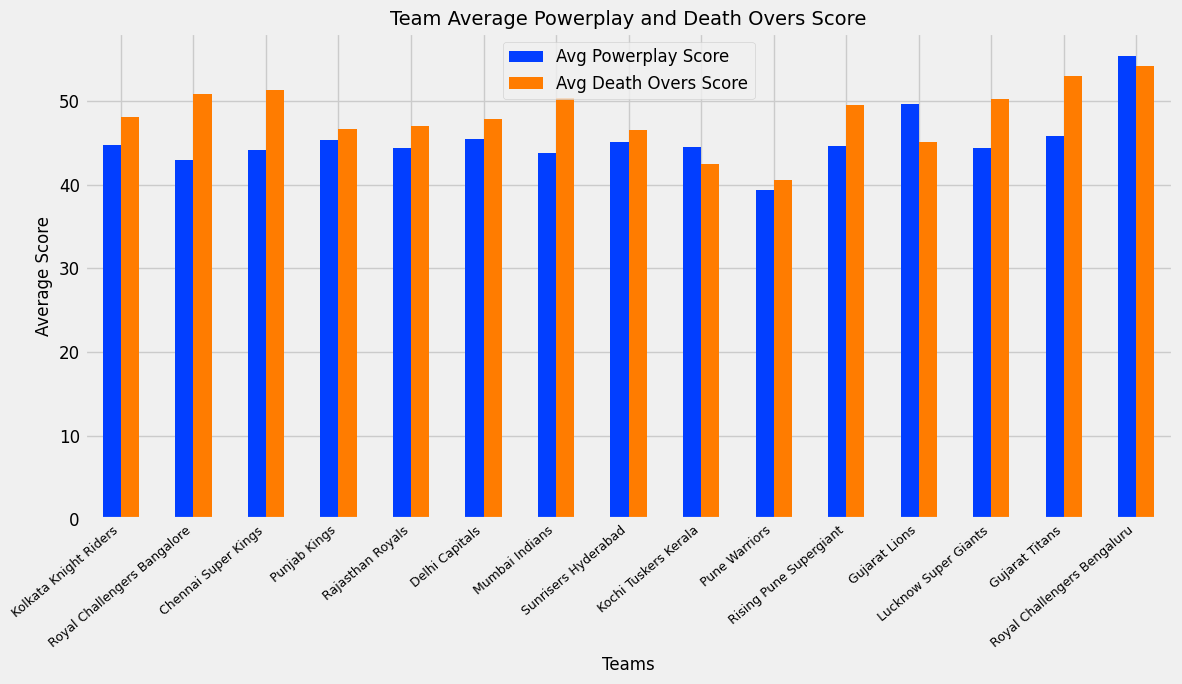

In [26]:

# Plot average powerplay and death overs score
plt.figure(figsize=(12, 7))
team_phase_scores.plot(kind='bar', figsize=(12, 7))
plt.title('Team Average Powerplay and Death Overs Score', fontsize=14)
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.xticks(rotation=40, ha='right', fontsize=9)
plt.legend(['Avg Powerplay Score', 'Avg Death Overs Score'])
plt.tight_layout()
plt.savefig('team_phase_scores.png')
plt.show()


In [27]:

# ------------------ SECTION 4: PLAYER PERFORMANCE ANALYSIS ------------------

print("\n" + "="*30 + " PLAYER PERFORMANCE ANALYSIS " + "="*30)

# 4.1 Batting Analysis
print("\n--- Batsmen Analysis ---")

# Calculate runs scored by each batsman
batsman_runs = deliveries.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False)
top_run_scorers = batsman_runs.head(20)

print("\nTop 20 Run Scorers:")
print(top_run_scorers)



============================== PLAYER PERFORMANCE ANALYSIS ==============================

--- Batsmen Analysis ---

Top 20 Run Scorers:
batter
V Kohli           8014
S Dhawan          6769
RG Sharma         6630
DA Warner         6567
SK Raina          5536
MS Dhoni          5243
AB de Villiers    5181
CH Gayle          4997
RV Uthappa        4954
KD Karthik        4843
KL Rahul          4689
AM Rahane         4642
F du Plessis      4571
SV Samson         4419
AT Rayudu         4348
G Gambhir         4217
SR Watson         3880
MK Pandey         3859
SA Yadav          3594
JC Buttler        3583
Name: batsman_runs, dtype: int64


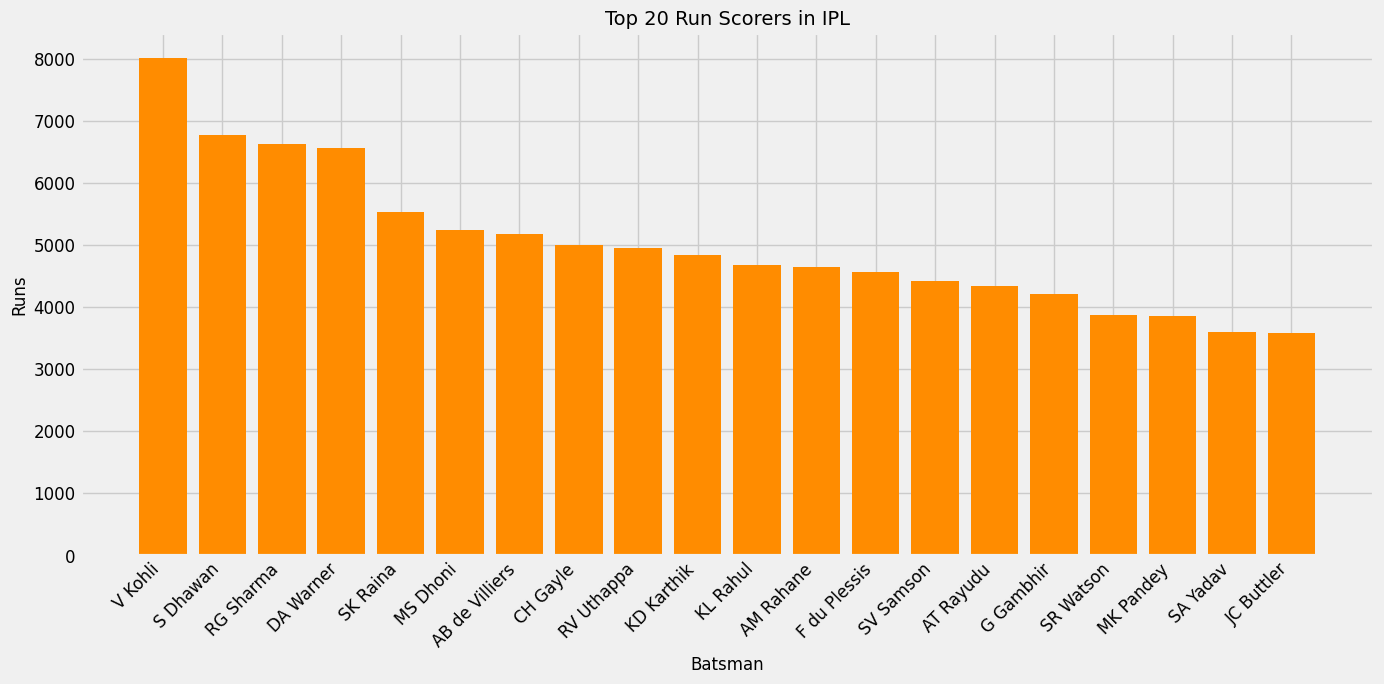

In [28]:

# Plot top 20 run scorers
plt.figure(figsize=(14, 7))
plt.bar(top_run_scorers.index, top_run_scorers.values, color='darkorange')
plt.title('Top 20 Run Scorers in IPL', fontsize=14)
plt.xlabel('Batsman', fontsize=12)
plt.ylabel('Runs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_run_scorers.png')
plt.show()


In [29]:

# Calculate batting average and strike rate for top run scorers
batsman_dismissals = deliveries[deliveries['is_wicket'] == 1].groupby('batter').size()
batsman_balls_faced = deliveries.groupby('batter').size()

batsman_stats = pd.DataFrame({
    'Runs': batsman_runs,
    'Dismissals': batsman_dismissals,
    'Balls_Faced': batsman_balls_faced
})

batsman_stats['Batting_Average'] = (batsman_stats['Runs'] / batsman_stats['Dismissals']).fillna(batsman_stats['Runs']).round(2)
batsman_stats['Strike_Rate'] = (batsman_stats['Runs'] / batsman_stats['Balls_Faced'] * 100).round(2)

# Filter for top 20 run scorers
top_batsman_stats = batsman_stats.loc[top_run_scorers.index]


In [30]:

print("\nBatting Average and Strike Rate for Top 20 Run Scorers:")
print(top_batsman_stats[['Batting_Average', 'Strike_Rate']])



Batting Average and Strike Rate for Top 20 Run Scorers:
                Batting_Average  Strike_Rate
batter                                      
V Kohli                   36.76       128.51
S Dhawan                  34.89       123.45
RG Sharma                 28.58       127.92
DA Warner                 40.04       135.43
SK Raina                  32.95       132.54
MS Dhoni                  35.19       132.84
AB de Villiers            41.45       148.58
CH Gayle                  39.04       142.12
RV Uthappa                26.92       126.15
KD Karthik                25.62       131.35
KL Rahul                  44.24       131.05
AM Rahane                 29.76       120.32
F du Plessis              36.57       133.07
SV Samson                 31.12       135.14
AT Rayudu                 28.61       124.58
G Gambhir                 31.24       119.67
SR Watson                 30.79       134.16
MK Pandey                 29.02       117.37
SA Yadav                  32.09       142.5

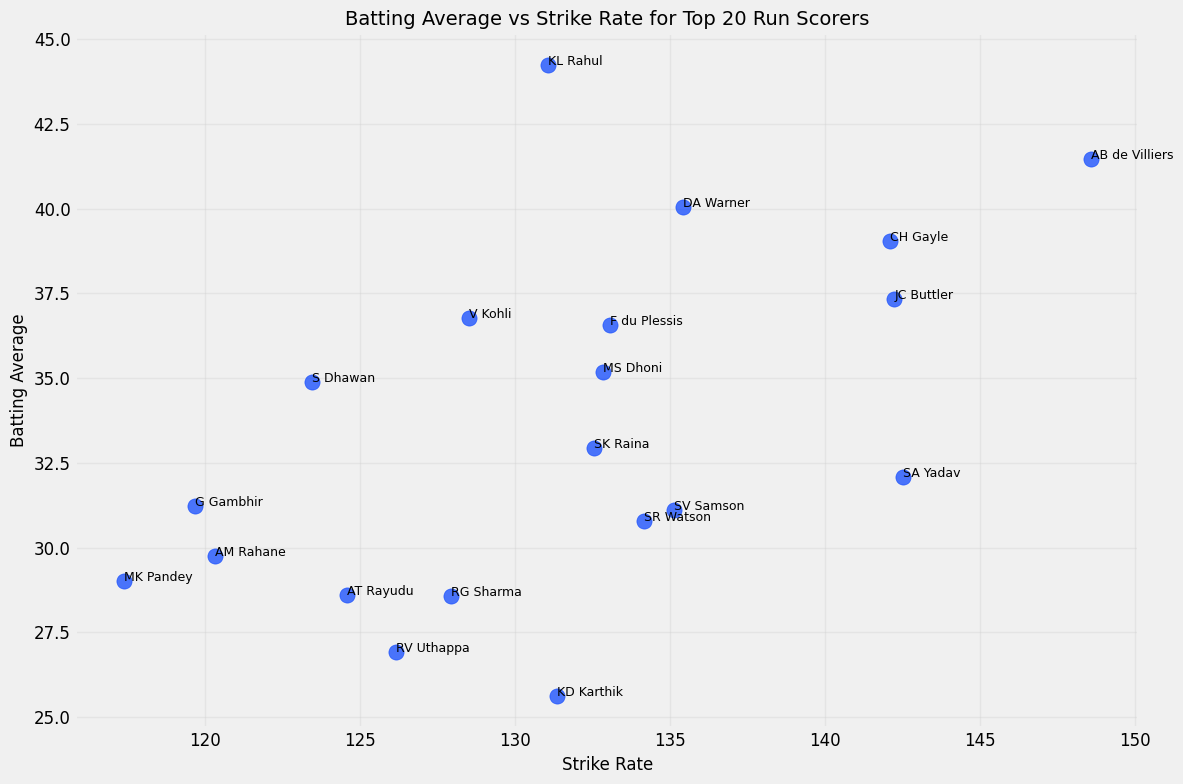

In [31]:

# Plot batting average vs strike rate for top 20 run scorers
plt.figure(figsize=(12, 8))
plt.scatter(top_batsman_stats['Strike_Rate'], top_batsman_stats['Batting_Average'], s=120, alpha=0.7)

for i, batsman in enumerate(top_batsman_stats.index):
    plt.annotate(batsman, 
                 (top_batsman_stats['Strike_Rate'].iloc[i], top_batsman_stats['Batting_Average'].iloc[i]),
                 fontsize=9)

plt.title('Batting Average vs Strike Rate for Top 20 Run Scorers', fontsize=14)
plt.xlabel('Strike Rate', fontsize=12)
plt.ylabel('Batting Average', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('batting_avg_vs_strike_rate.png')
plt.show()


In [32]:

# Find highest average and strike rate for players with >50 matches
# First, count matches played by each player
player_matches = {}
for player in batsman_stats.index:
    match_ids = deliveries[deliveries['batter'] == player]['match_id'].unique()
    player_matches[player] = len(match_ids)

batsman_stats['Matches_Played'] = pd.Series(player_matches)

# Filter for players with >50 matches
qualified_players = batsman_stats[batsman_stats['Matches_Played'] > 50]
highest_avg_player = qualified_players.loc[qualified_players['Batting_Average'].idxmax()]
highest_sr_player = qualified_players.loc[qualified_players['Strike_Rate'].idxmax()]

print(f"\nPlayer with Highest Average (>50 matches): {highest_avg_player.name} - {highest_avg_player['Batting_Average']}")
print(f"Player with Highest Strike Rate (>50 matches): {highest_sr_player.name} - {highest_sr_player['Strike_Rate']}")

# Calculate batsman categories (4s, 6s, etc.)
batsman_6s = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size()
batsman_4s = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size()
batsman_2s = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size()
batsman_1s = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size()

# Get top 10 in each category
top_6s = batsman_6s.sort_values(ascending=False).head(10)
top_4s = batsman_4s.sort_values(ascending=False).head(10)
top_2s = batsman_2s.sort_values(ascending=False).head(10)
top_1s = batsman_1s.sort_values(ascending=False).head(10)



Player with Highest Average (>50 matches): KL Rahul - 44.24
Player with Highest Strike Rate (>50 matches): AD Russell - 164.22


In [33]:

print("\nTop 10 Batsmen by 6s:")
print(top_6s)



Top 10 Batsmen by 6s:
batter
CH Gayle          359
RG Sharma         281
V Kohli           273
AB de Villiers    253
MS Dhoni          252
DA Warner         236
KA Pollard        224
AD Russell        209
SV Samson         206
SK Raina          204
dtype: int64


In [34]:

print("\nTop 10 Batsmen by 4s:")
print(top_4s)



Top 10 Batsmen by 4s:
batter
S Dhawan        768
V Kohli         708
DA Warner       663
RG Sharma       599
SK Raina        506
G Gambhir       492
RV Uthappa      481
AM Rahane       479
KD Karthik      466
F du Plessis    422
dtype: int64


In [35]:

# Find highest individual scores
batsman_match_runs = deliveries.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()
print("\nTop 20 Highest Individual Scores:")
highest_scores = batsman_match_runs.sort_values('batsman_runs', ascending=False).head(20)[['batter', 'batsman_runs']]
print(highest_scores)



Top 20 Highest Individual Scores:
               batter  batsman_runs
5302         CH Gayle           175
2         BB McCullum           158
14108       Q de Kock           140
7528   AB de Villiers           133
11583        KL Rahul           132
15383    Shubman Gill           129
8359   AB de Villiers           129
4687         CH Gayle           128
10149         RR Pant           128
2237          M Vijay           127
9146        DA Warner           126
14915     YBK Jaiswal           124
16000      MP Stoinis           124
12571      JC Buttler           124
6854         V Sehwag           122
2788      PC Valthaty           120
12221       SV Samson           119
3325         V Sehwag           119
7460         CH Gayle           117
10417       SR Watson           117


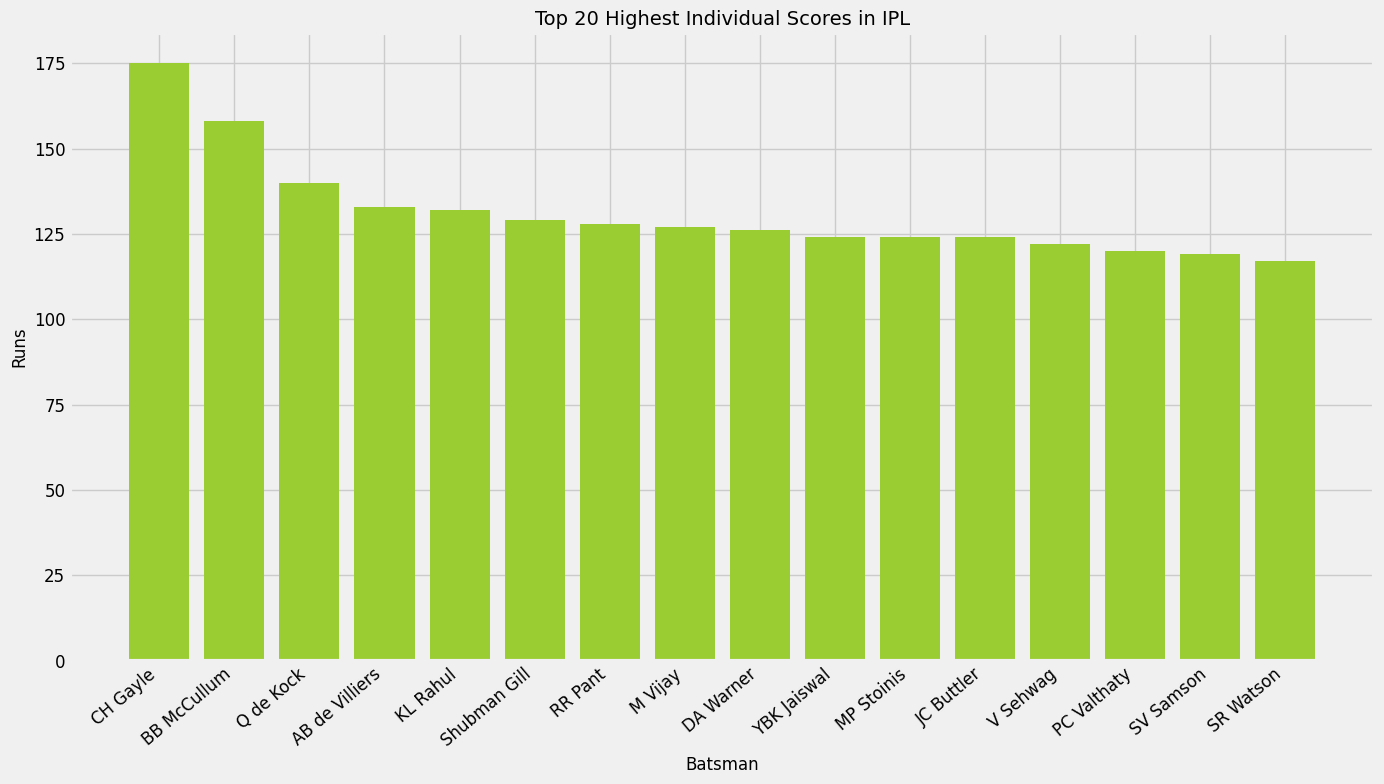

In [36]:

# Plot highest individual scores
plt.figure(figsize=(14, 8))
plt.bar(highest_scores['batter'], highest_scores['batsman_runs'], color='yellowgreen')
plt.title('Top 20 Highest Individual Scores in IPL', fontsize=14)
plt.xlabel('Batsman', fontsize=12)
plt.ylabel('Runs', fontsize=12)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('highest_individual_scores.png')
plt.show()


In [37]:

# 4.2 Bowling Analysis
print("\n--- Bowlers Analysis ---")

# Calculate wickets taken by each bowler
bowler_wickets = deliveries[deliveries['is_wicket'] == 1].groupby('bowler').size().sort_values(ascending=False)
top_wicket_takers = bowler_wickets.head(20)

print("\nTop 20 Wicket Takers:")
print(top_wicket_takers)



--- Bowlers Analysis ---

Top 20 Wicket Takers:
bowler
YS Chahal          213
DJ Bravo           207
PP Chawla          201
SP Narine          200
R Ashwin           198
B Kumar            195
SL Malinga         188
A Mishra           183
JJ Bumrah          182
RA Jadeja          169
UT Yadav           163
Harbhajan Singh    161
Rashid Khan        157
Sandeep Sharma     153
HV Patel           151
MM Sharma          147
Mohammed Shami     144
AR Patel           131
TA Boult           128
R Vinay Kumar      127
dtype: int64


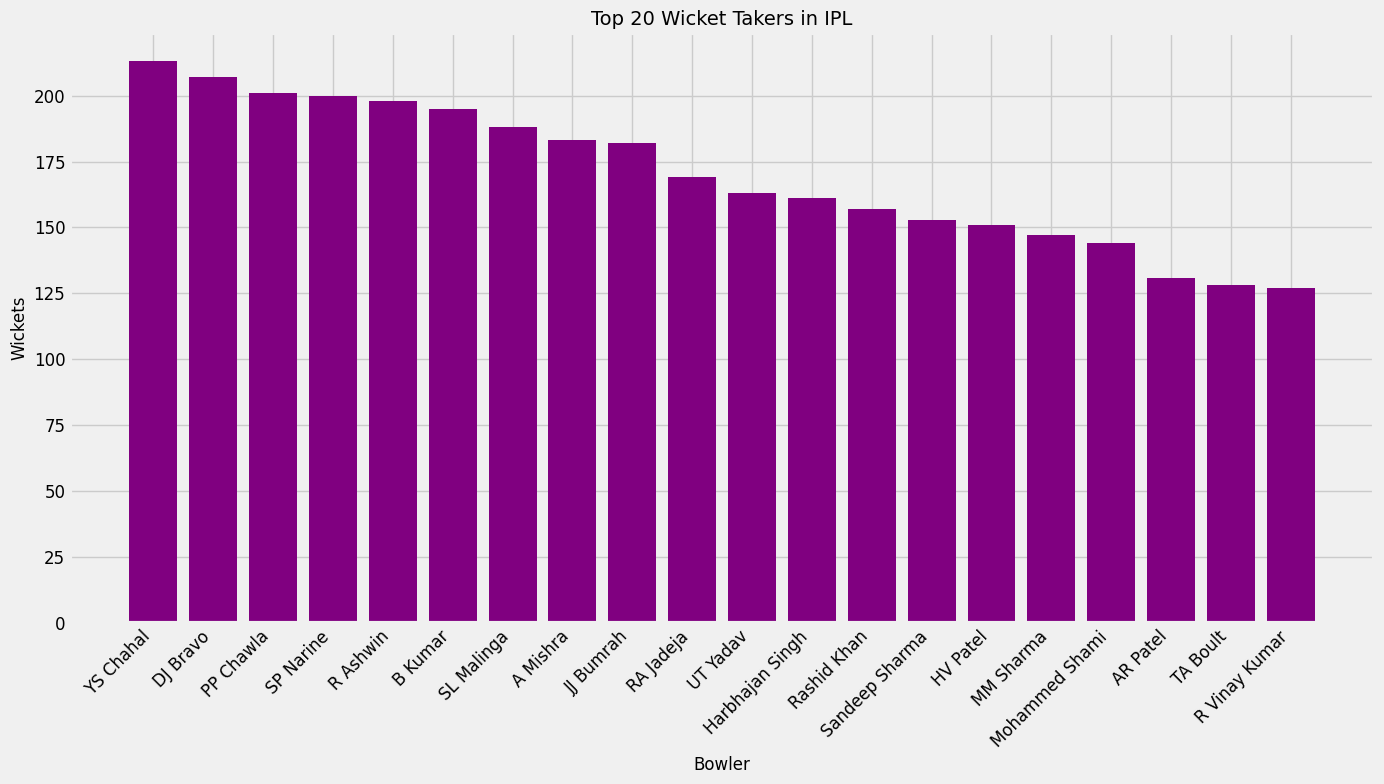

In [38]:

# Plot top wicket takers
plt.figure(figsize=(14, 8))
plt.bar(top_wicket_takers.index, top_wicket_takers.values, color='purple')
plt.title('Top 20 Wicket Takers in IPL', fontsize=14)
plt.xlabel('Bowler', fontsize=12)
plt.ylabel('Wickets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_wicket_takers.png')
plt.show()


In [39]:

# Calculate overs bowled
overs_bowled = deliveries.groupby('bowler').size() / 6

# Create a dataframe with bowlers and overs bowled
bowler_overs = pd.DataFrame({
    'bowler': overs_bowled.index,
    'over': overs_bowled.values.round(1)  # Round to 1 decimal place
})

# Sort by overs bowled in descending order
bowler_overs = bowler_overs.sort_values('over', ascending=False).reset_index(drop=True)

# Display the top 10 bowlers by overs bowled
print("\nTop 10 Bowlers by Overs Bowled:")
print(bowler_overs.head(10))



Top 10 Bowlers by Overs Bowled:
            bowler   over
0         R Ashwin  779.8
1        SP Narine  691.0
2          B Kumar  676.7
3        PP Chawla  649.2
4        RA Jadeja  649.2
5        YS Chahal  604.7
6  Harbhajan Singh  582.7
7         A Mishra  574.0
8         DJ Bravo  549.3
9         UT Yadav  531.7


In [40]:

# Calculate bowling economy rates
eligible_df = deliveries[deliveries['bowler'].isin(bowler_overs['bowler'])]
total_runs = eligible_df.groupby('bowler')['total_runs'].sum().reset_index().sort_values(by='bowler')
merged_df = bowler_overs.merge(total_runs, on='bowler', how='inner')
merged_df['bowling_eco'] = merged_df['total_runs'] / merged_df['over']

print("\nTop 10 Bowlers by Economy Rate (min 50 overs):")
print(merged_df[merged_df['over'] > 50].sort_values('bowling_eco').head(10)[['bowler', 'over', 'bowling_eco']])

# 4.3 Man of the Match Analysis
mom_counts = matches['player_of_match'].value_counts().head(20)

print("\nTop 20 Players with Most Man of the Match Awards:")
print(mom_counts)



Top 10 Bowlers by Economy Rate (min 50 overs):
               bowler   over  bowling_eco
81           A Kumble  163.8     6.648352
184        GD McGrath   54.8     6.678832
47     M Muralitharan  263.5     6.698292
168           J Yadav   66.3     6.742081
1           SP Narine  691.0     6.761216
21           DW Steyn  380.3     6.792006
152  RE van der Merwe   75.8     6.794195
103        DL Vettori  130.8     6.834862
14        Rashid Khan  483.5     6.907963
113           J Botha  118.2     6.920474

Top 20 Players with Most Man of the Match Awards:
player_of_match
AB de Villiers    25
CH Gayle          22
RG Sharma         19
DA Warner         18
V Kohli           18
MS Dhoni          17
RA Jadeja         16
YK Pathan         16
SR Watson         16
AD Russell        15
SP Narine         15
KA Pollard        14
SK Raina          14
G Gambhir         13
KL Rahul          13
AM Rahane         13
JC Buttler        13
A Mishra          12
Rashid Khan       12
S Dhawan          12
Nam

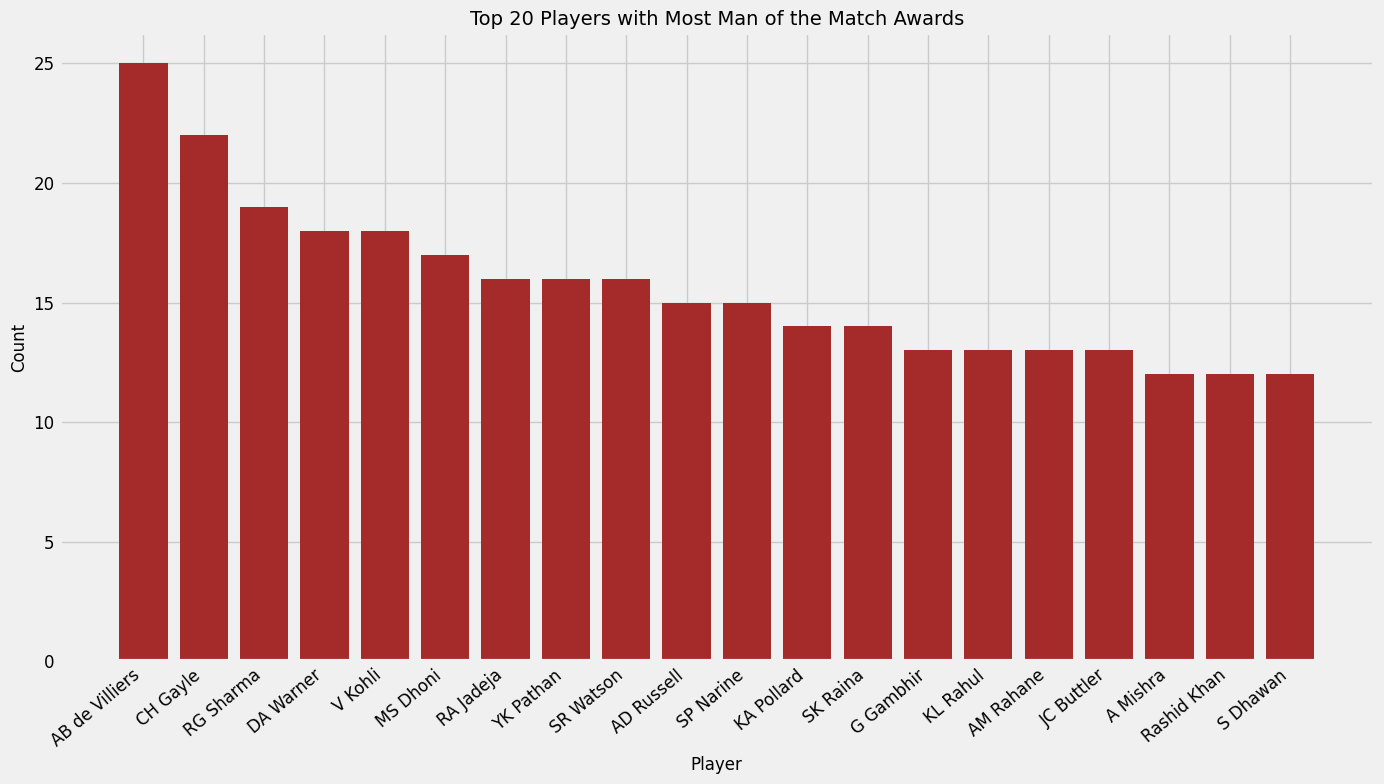

In [41]:

# Plot Man of the Match counts
plt.figure(figsize=(14, 8))
plt.bar(mom_counts.index, mom_counts.values, color='brown')
plt.title('Top 20 Players with Most Man of the Match Awards', fontsize=14)
plt.xlabel('Player', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('mom_counts.png')
plt.show()


In [42]:

# ------------------ SECTION 5: SEASONAL ANALYSIS ------------------

print("\n" + "="*30 + " SEASONAL ANALYSIS " + "="*30)

# 5.1 Average Runs Per Season
# Calculate total runs for each match
match_runs = deliveries.groupby('match_id')['total_runs'].sum().reset_index()

# Merge match_runs with matches DataFrame
matches_with_runs = pd.merge(matches, match_runs, left_on='id', right_on='match_id')

# Extract year from date for seasonal analysis
matches_with_runs['season'] = pd.to_datetime(matches_with_runs['date']).dt.year

# Calculate average runs per match per season
season_runs = matches_with_runs.groupby('season')['total_runs'].sum()
season_matches = matches_with_runs.groupby('season').size()
avg_runs_per_season = (season_runs / season_matches).round(2)

avg_runs_df = pd.DataFrame({'Season': avg_runs_per_season.index, 'Avg_Runs_Per_Match': avg_runs_per_season.values})
print("\nAverage Runs Per Match Per Season:")
print(avg_runs_df)



============================== SEASONAL ANALYSIS ==============================

Average Runs Per Match Per Season:
    Season  Avg_Runs_Per_Match
0     2008              309.26
1     2009              286.89
2     2010              314.72
3     2011              289.78
4     2012              303.42
5     2013              297.39
6     2014              315.52
7     2015              311.07
8     2016              314.37
9     2017              318.41
10    2018              331.68
11    2019              323.90
12    2020              323.60
13    2021              310.62
14    2022              329.66
15    2023              347.14
16    2024              365.79


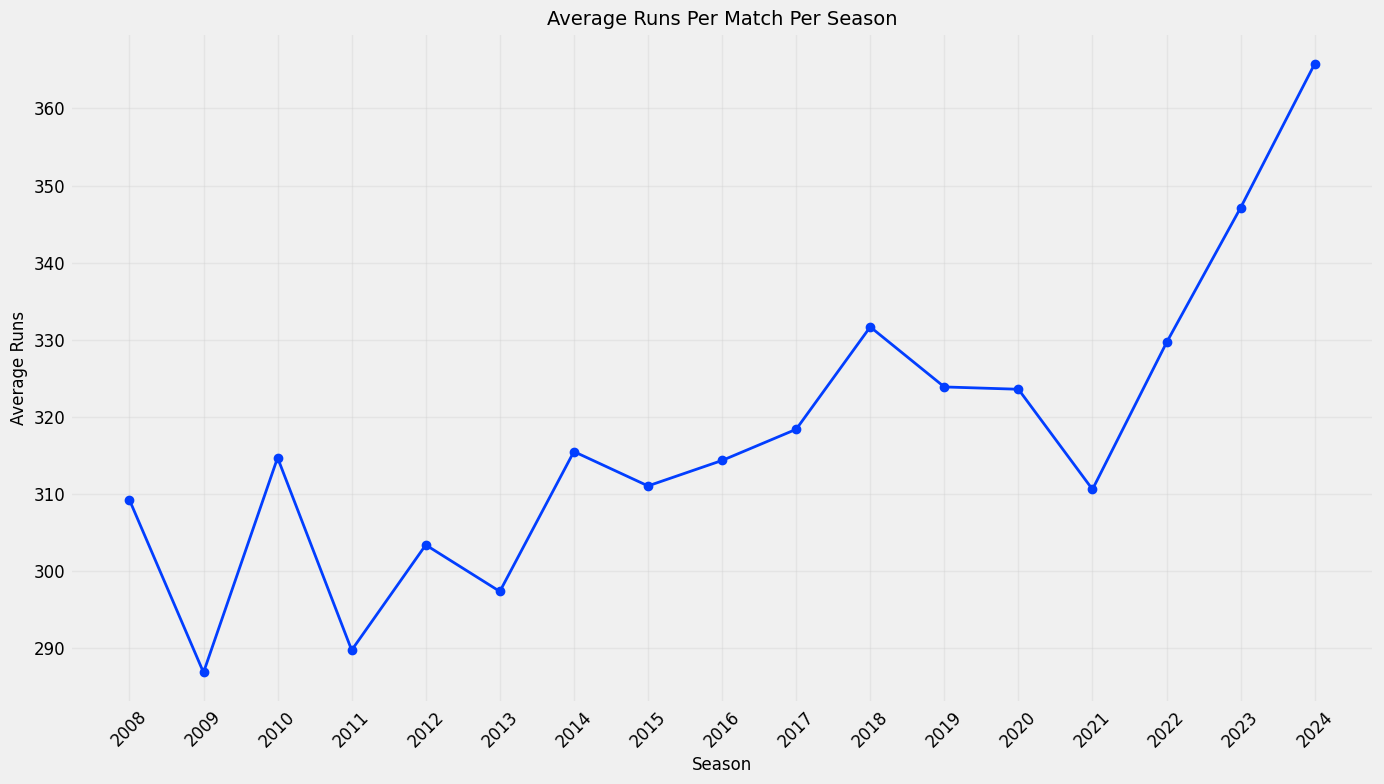

In [43]:

# Plot average runs per match per season
plt.figure(figsize=(14, 8))
plt.plot(avg_runs_df['Season'], avg_runs_df['Avg_Runs_Per_Match'], marker='o', linewidth=2)
plt.title('Average Runs Per Match Per Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Runs', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(avg_runs_df['Season'], rotation=45)
plt.tight_layout()
plt.savefig('avg_runs_per_season.png')
plt.show()


In [44]:

# 5.2 High Scores Per Season
# Identify targets of 200+ runs per season
# First, calculate total runs per match per team
match_team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Filter for scores of 200 or more
high_scores_matches = match_team_runs[match_team_runs['total_runs'] >= 200]

# Merge with matches to get the season information
high_scores_with_season = pd.merge(high_scores_matches, 
                                   matches[['id', 'season']], 
                                   left_on='match_id', 
                                   right_on='id',
                                   how='inner',
                                   validate='many_to_one')

# Count high scores per season
high_scores = high_scores_with_season.groupby('season').size()
high_scores_df = pd.DataFrame({'Season': high_scores.index, '200+_Scores': high_scores.values})

print("\nNumber of 200+ Scores Per Season:")
print(high_scores_df)



Number of 200+ Scores Per Season:
     Season  200+_Scores
0   2007/08           11
1      2009            1
2   2009/10            9
3      2011            5
4      2012            5
5      2013            4
6      2014            9
7      2015            8
8      2016            6
9      2017           10
10     2018           15
11     2019           11
12  2020/21           13
13     2021            9
14     2022           18
15     2023           37
16     2024           41


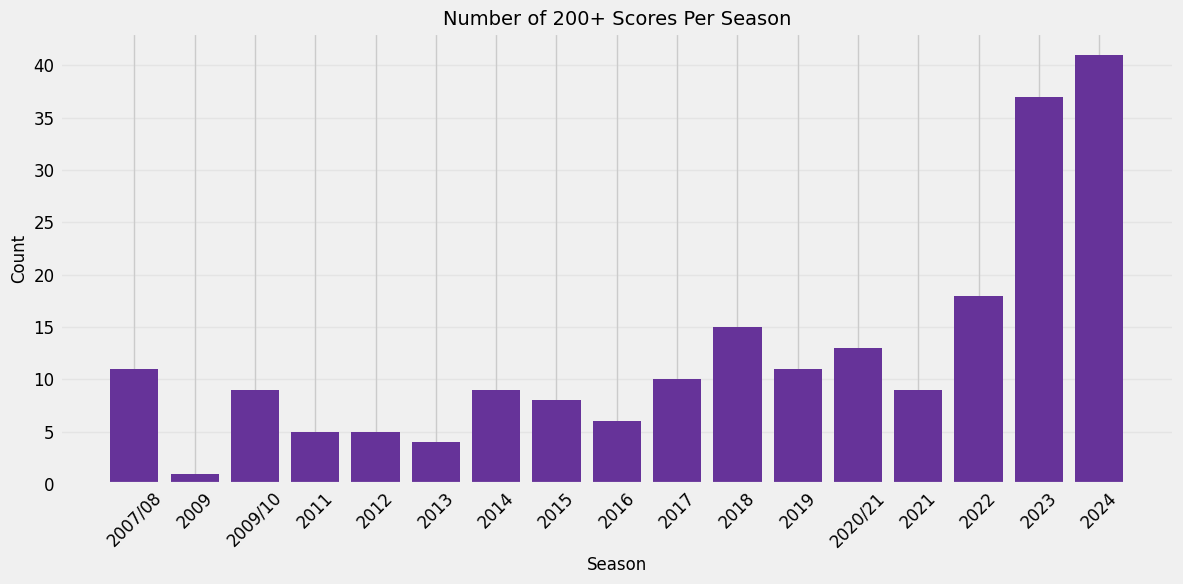

In [45]:

# Plot 200+ scores per season
plt.figure(figsize=(12, 6))
plt.bar(high_scores_df['Season'], high_scores_df['200+_Scores'], color='rebeccapurple')
plt.title('Number of 200+ Scores Per Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(high_scores_df['Season'], rotation=45)
plt.tight_layout()
plt.savefig('high_scores_per_season.png')
plt.show()


In [46]:

# 5.3 Team Performance by Season
# Find average score of each team per season
# First, calculate total runs per match per team
match_team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Get season information from matches DataFrame
match_seasons = matches[['id', 'season']].copy()
match_seasons.rename(columns={'id': 'match_id'}, inplace=True)

# Merge to get season information for each match-team combination
team_season_runs = pd.merge(match_team_runs, match_seasons, on='match_id')

# Group by season and team to calculate average score
team_season_avg = team_season_runs.groupby(['season', 'batting_team'])['total_runs'].mean().reset_index()
team_season_avg.columns = ['season', 'Team', 'Avg_Score']

# Sort values for better readability
team_season_df = team_season_avg.sort_values(['season', 'Team'])

print("\nAverage Score of Each Team Per Season (Sample):")
print(team_season_df.tail(20))



Average Score of Each Team Per Season (Sample):
    season                         Team   Avg_Score
126   2023          Chennai Super Kings  180.800000
127   2023               Delhi Capitals  155.857143
128   2023               Gujarat Titans  179.647059
129   2023        Kolkata Knight Riders  175.928571
130   2023         Lucknow Super Giants  165.266667
131   2023               Mumbai Indians  184.062500
132   2023                 Punjab Kings  182.571429
133   2023             Rajasthan Royals  172.785714
134   2023  Royal Challengers Bangalore  178.714286
135   2023          Sunrisers Hyderabad  169.714286
136   2024          Chennai Super Kings  180.285714
137   2024               Delhi Capitals  183.785714
138   2024               Gujarat Titans  170.000000
139   2024        Kolkata Knight Riders  190.500000
140   2024         Lucknow Super Giants  177.357143
141   2024               Mumbai Indians  183.428571
142   2024                 Punjab Kings  177.642857
143   2024     

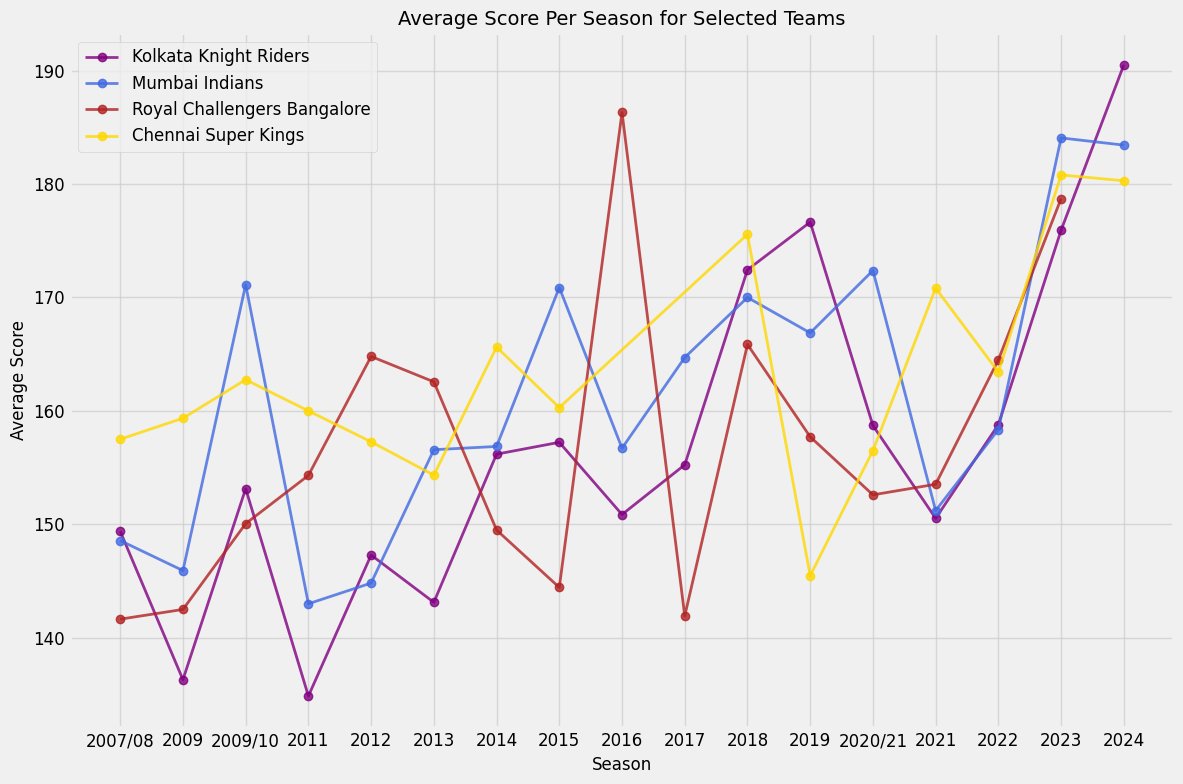

In [47]:

# Plot team performance over seasons
team_colors = {
    'Kolkata Knight Riders': 'purple',
    'Mumbai Indians': 'royalblue',
    'Royal Challengers Bangalore': 'firebrick',
    'Chennai Super Kings': 'gold'
}

# Plot average score for a few selected teams across seasons
selected_teams = ['Kolkata Knight Riders', 'Mumbai Indians', 'Royal Challengers Bangalore', 'Chennai Super Kings']
plt.figure(figsize=(12, 8))

for team in selected_teams:
    team_data = team_season_df[team_season_df['Team'] == team]
    if not team_data.empty:
        plt.plot(
            team_data['season'],
            team_data['Avg_Score'],
            marker='o',
            linewidth=2,
            label=team,
            color=team_colors.get(team, 'gray'),
            alpha=0.8
        )

plt.title('Average Score Per Season for Selected Teams', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.grid(True, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('team_avg_score_per_season.png')
plt.show()


In [48]:

# 5.4 Orange Cap Analysis (Top Run Scorers by Season)
def orange_cap_analysis():
    # Create DataFrame for Orange Cap holders
    orange_cap_data = {
        'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
        'Player': ['Shaun Marsh', 'Matthew Hayden', 'Sachin Tendulkar', 'Chris Gayle', 'Chris Gayle', 'Michael Hussey', 
                   'Robin Uthappa', 'David Warner', 'Virat Kohli', 'David Warner', 'Kane Williamson', 'David Warner', 
                   'KL Rahul', 'Ruturaj Gaikwad', 'Jos Buttler', 'Shubman Gill', 'Virat Kohli'],
        'Team': ['KXIP', 'CSK', 'MI', 'RCB', 'RCB', 'CSK', 'KKR', 'SRH', 'RCB', 'SRH', 'SRH', 'SRH', 
                 'KXIP', 'CSK', 'RR', 'GT', 'RCB'],
        'Runs': [616, 572, 618, 608, 733, 733, 660, 562, 973, 641, 735, 692, 670, 635, 863, 890, 741],
        'Average': [68.0, 51.0, 47.0, 67.0, 61.0, 52.0, 44.0, 43.0, 81.0, 58.27, 52.5, 69.2, 55.83, 45.35, 57.53, 59.33, 49.4],
        'Strike_Rate': [139.0, 144.0, 132.0, 183.0, 160.0, 129.0, 137.0, 156.0, 152.0, 141.81, 142.44, 143.87, 129.34, 136.26, 149.05, 157.8, 155.0]
    }

    orange_cap_df = pd.DataFrame(orange_cap_data)
    
    print("\nOrange Cap Holders (Top Run Scorers) by Season:")
    print(orange_cap_df)

    # Plot runs scored by Orange Cap holders across seasons
    plt.figure(figsize=(14, 8))
    bars = plt.bar(orange_cap_df['Season'], orange_cap_df['Runs'], color='orange')
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Runs Scored', fontsize=12)
    plt.title('Runs Scored by Orange Cap Holders (2008-2024)', fontsize=14)
    plt.xticks(orange_cap_df['Season'], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add player names on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                 orange_cap_df['Player'][i], ha='center', rotation=40, fontsize=9)

    plt.tight_layout()
    plt.savefig('orange_cap_runs.png')
    plt.show()


In [50]:

    def orange_cap_analysis():
        # Create DataFrame for Orange Cap holders
        orange_cap_data = {
            'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
            'Player': ['Shaun Marsh', 'Matthew Hayden', 'Sachin Tendulkar', 'Chris Gayle', 'Chris Gayle', 'Michael Hussey', 
                       'Robin Uthappa', 'David Warner', 'Virat Kohli', 'David Warner', 'Kane Williamson', 'David Warner', 
                       'KL Rahul', 'Ruturaj Gaikwad', 'Jos Buttler', 'Shubman Gill', 'Virat Kohli'],
            'Team': ['KXIP', 'CSK', 'MI', 'RCB', 'RCB', 'CSK', 'KKR', 'SRH', 'RCB', 'SRH', 'SRH', 'SRH', 
                     'KXIP', 'CSK', 'RR', 'GT', 'RCB'],
            'Runs': [616, 572, 618, 608, 733, 733, 660, 562, 973, 641, 735, 692, 670, 635, 863, 890, 741],
            'Average': [68.0, 51.0, 47.0, 67.0, 61.0, 52.0, 44.0, 43.0, 81.0, 58.27, 52.5, 69.2, 55.83, 45.35, 57.53, 59.33, 49.4],
            'Strike_Rate': [139.0, 144.0, 132.0, 183.0, 160.0, 129.0, 137.0, 156.0, 152.0, 141.81, 142.44, 143.87, 129.34, 136.26, 149.05, 157.8, 155.0]
        }
    
        orange_cap_df = pd.DataFrame(orange_cap_data)
        
        print("\nOrange Cap Holders (Top Run Scorers) by Season:")
        print(orange_cap_df)
    
        # Plot runs scored by Orange Cap holders across seasons
        plt.figure(figsize=(14, 8))
        bars = plt.bar(orange_cap_df['Season'], orange_cap_df['Runs'], color='orange')
        plt.xlabel('Season', fontsize=12)
        plt.ylabel('Runs Scored', fontsize=12)
        plt.title('Runs Scored by Orange Cap Holders (2008-2024)', fontsize=14)
        plt.xticks(orange_cap_df['Season'], rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add player names on top of bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                     orange_cap_df['Player'][i], ha='center', rotation=40, fontsize=9)
    
        plt.tight_layout()
        plt.savefig('orange_cap_runs.png')
        plt.show()
        
        # Analyze strike rate vs average for Orange Cap holders
        plt.figure(figsize=(14, 8))
        scatter = plt.scatter(orange_cap_df['Strike_Rate'], orange_cap_df['Average'], 
                             s=orange_cap_df['Runs']/5, alpha=0.7, c=orange_cap_df['Season'], cmap='viridis')
    
        # Add player names as annotations
        for i, player in enumerate(orange_cap_df['Player']):
            plt.annotate(f"{player} ({orange_cap_df['Season'][i]})", 
                        (orange_cap_df['Strike_Rate'][i], orange_cap_df['Average'][i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
        plt.xlabel('Strike Rate', fontsize=12)
        plt.ylabel('Batting Average', fontsize=12)
        plt.title('Strike Rate vs Average for Orange Cap Holders', fontsize=14)
        plt.colorbar(scatter, label='Season')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('orange_cap_sr_vs_avg.png')
        plt.show()



Orange Cap Holders (Top Run Scorers) by Season:
    Season            Player  Team  Runs  Average  Strike_Rate
0     2008       Shaun Marsh  KXIP   616    68.00       139.00
1     2009    Matthew Hayden   CSK   572    51.00       144.00
2     2010  Sachin Tendulkar    MI   618    47.00       132.00
3     2011       Chris Gayle   RCB   608    67.00       183.00
4     2012       Chris Gayle   RCB   733    61.00       160.00
5     2013    Michael Hussey   CSK   733    52.00       129.00
6     2014     Robin Uthappa   KKR   660    44.00       137.00
7     2015      David Warner   SRH   562    43.00       156.00
8     2016       Virat Kohli   RCB   973    81.00       152.00
9     2017      David Warner   SRH   641    58.27       141.81
10    2018   Kane Williamson   SRH   735    52.50       142.44
11    2019      David Warner   SRH   692    69.20       143.87
12    2020          KL Rahul  KXIP   670    55.83       129.34
13    2021   Ruturaj Gaikwad   CSK   635    45.35       136.26
14    

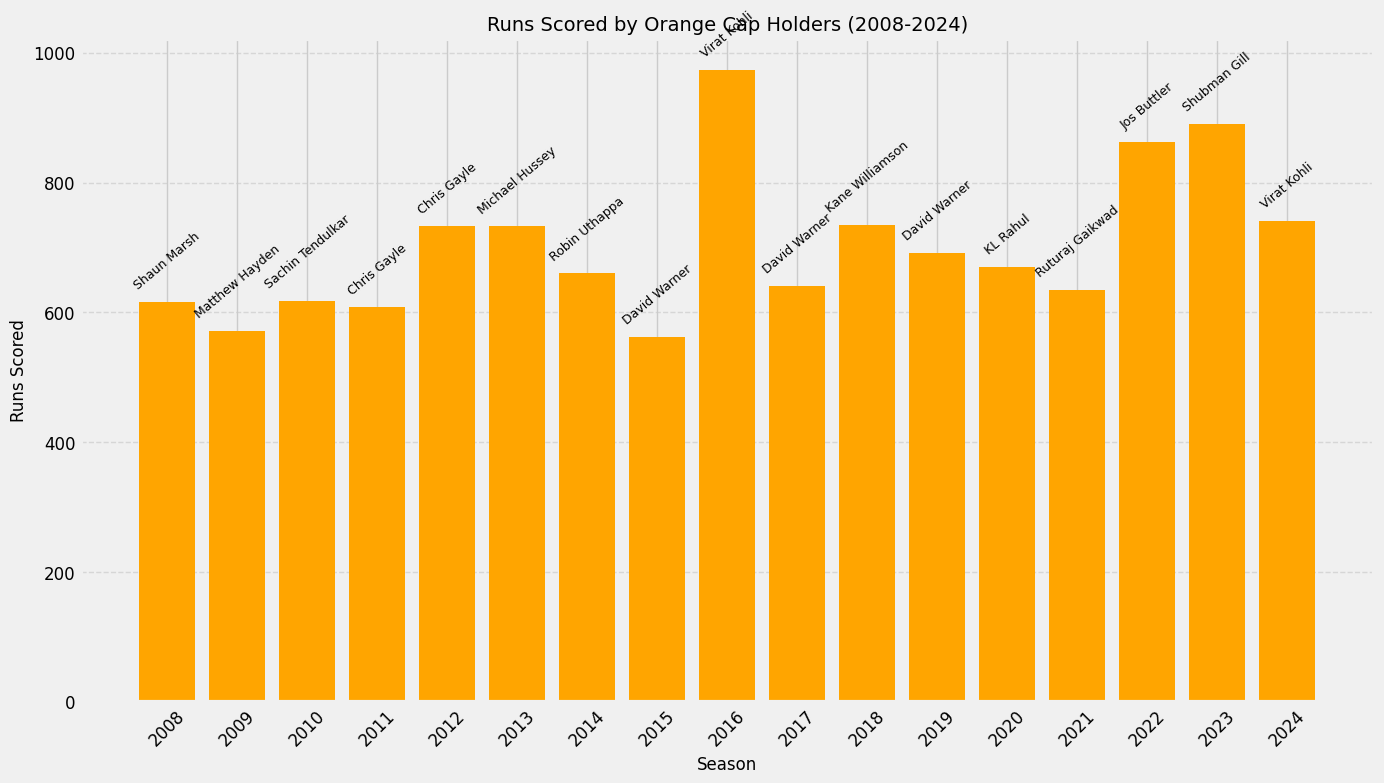

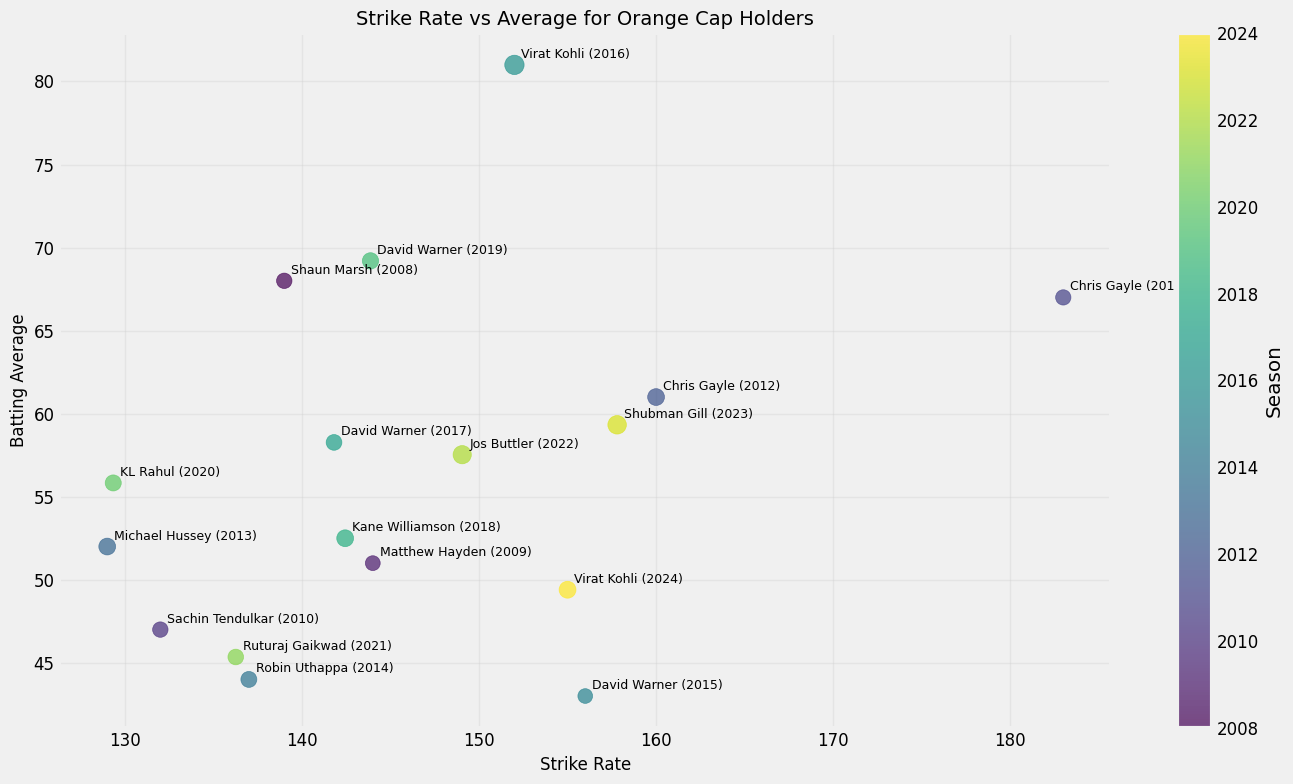

In [51]:

# Run the Orange Cap analysis
orange_cap_analysis()



Purple Cap Holders (Top Wicket Takers) by Season:
    Season             Player  Team  Wickets  Matches  Economy  Average
0     2008      Sohail Tanvir    RR       22       11     6.46    12.09
1     2009           RP Singh    DC       23       16     6.98    18.13
2     2010       Pragyan Ojha    DC       21       16     7.29    20.42
3     2011     Lasith Malinga    MI       28       16     5.95    13.39
4     2012       Morne Morkel    DD       25       16     7.19    18.12
5     2013       Dwayne Bravo   CSK       32       18     7.95    15.53
6     2014       Mohit Sharma   CSK       23       16     8.39    19.65
7     2015       Dwayne Bravo   CSK       26       17     8.14    16.38
8     2016  Bhuvneshwar Kumar   SRH       23       17     7.42    21.30
9     2017  Bhuvneshwar Kumar   SRH       26       14     7.05    14.19
10    2018         Andrew Tye  KXIP       24       14     8.00    18.66
11    2019        Imran Tahir   CSK       26       17     6.69    16.57
12    2020   

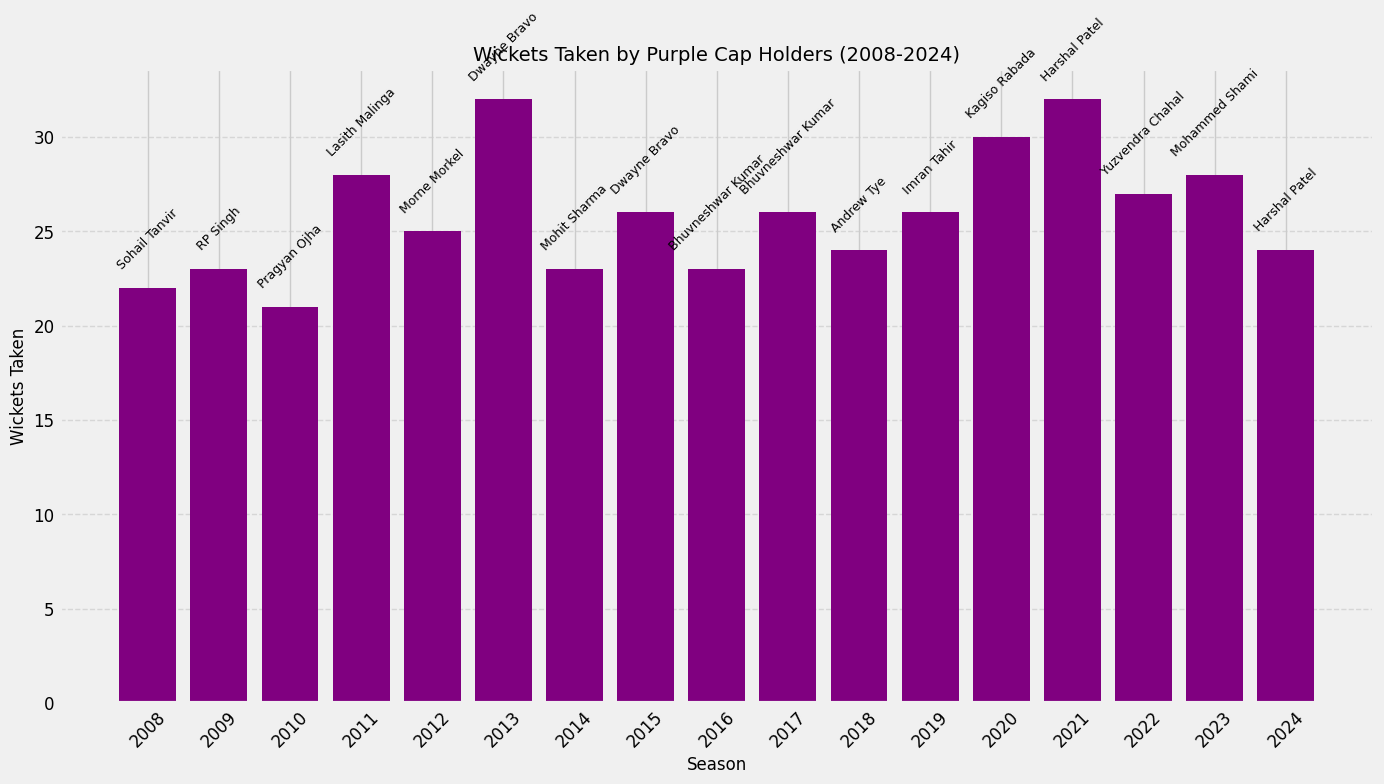

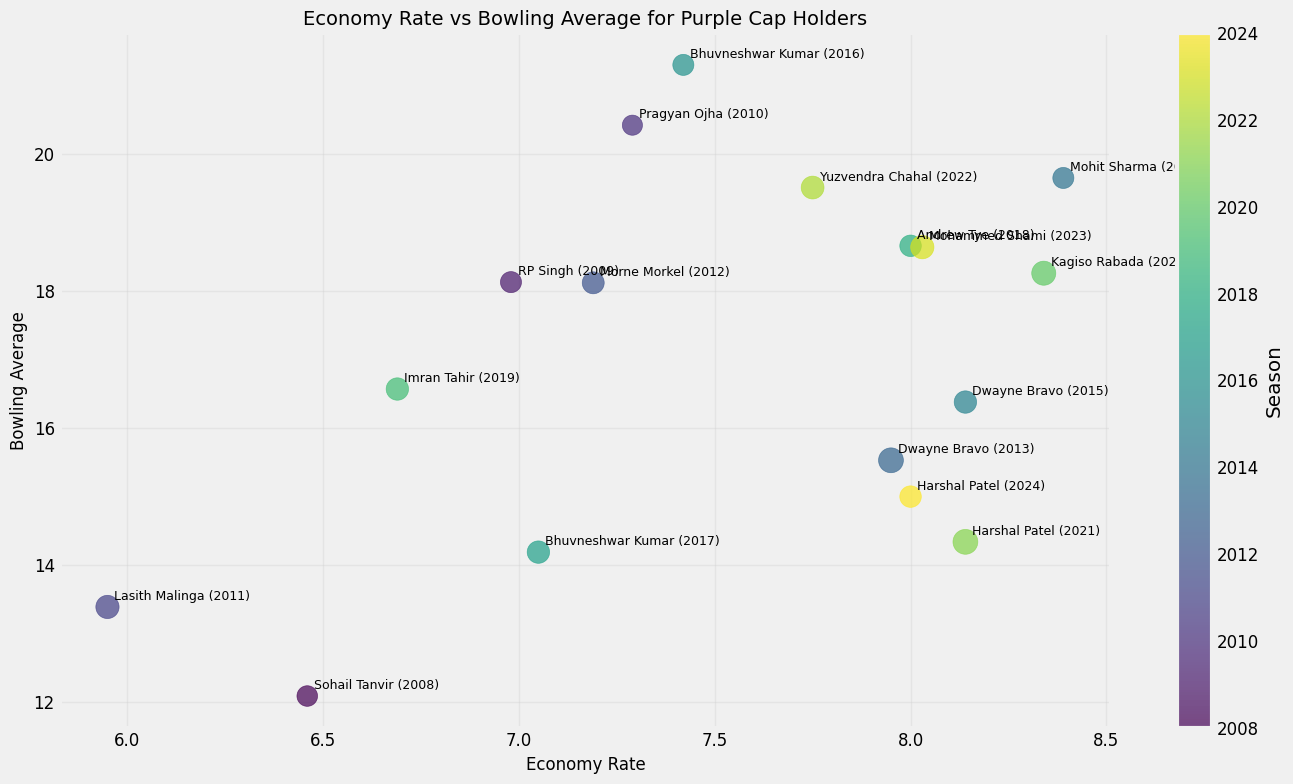

In [52]:

# 5.5 Purple Cap Analysis (Top Wicket Takers by Season)
def purple_cap_analysis():
    # Create DataFrame for Purple Cap holders
    purple_cap_data = {
        'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
        'Player': ['Sohail Tanvir', 'RP Singh', 'Pragyan Ojha', 'Lasith Malinga', 'Morne Morkel', 'Dwayne Bravo', 
                   'Mohit Sharma', 'Dwayne Bravo', 'Bhuvneshwar Kumar', 'Bhuvneshwar Kumar', 'Andrew Tye', 
                   'Imran Tahir', 'Kagiso Rabada', 'Harshal Patel', 'Yuzvendra Chahal', 'Mohammed Shami', 'Harshal Patel'],
        'Team': ['RR', 'DC', 'DC', 'MI', 'DD', 'CSK', 'CSK', 'CSK', 'SRH', 'SRH', 'KXIP', 'CSK', 'DC', 'RCB', 'RR', 'GT', 'PBKS'],
        'Wickets': [22, 23, 21, 28, 25, 32, 23, 26, 23, 26, 24, 26, 30, 32, 27, 28, 24],
        'Matches': [11, 16, 16, 16, 16, 18, 16, 17, 17, 14, 14, 17, 17, 15, 17, 17, 14],
        'Economy': [6.46, 6.98, 7.29, 5.95, 7.19, 7.95, 8.39, 8.14, 7.42, 7.05, 8.00, 6.69, 8.34, 8.14, 7.75, 8.03, 8.00],
        'Average': [12.09, 18.13, 20.42, 13.39, 18.12, 15.53, 19.65, 16.38, 21.30, 14.19, 18.66, 16.57, 18.26, 14.34, 19.51, 18.64, 15.00]
    }

    purple_cap_df = pd.DataFrame(purple_cap_data)
    
    print("\nPurple Cap Holders (Top Wicket Takers) by Season:")
    print(purple_cap_df)

    # Calculate wickets per match
    purple_cap_df['Wickets_per_Match'] = (purple_cap_df['Wickets'] / purple_cap_df['Matches']).round(2)

    # Plot wickets taken by Purple Cap holders across seasons
    plt.figure(figsize=(14, 8))
    bars = plt.bar(purple_cap_df['Season'], purple_cap_df['Wickets'], color='purple')
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Wickets Taken', fontsize=12)
    plt.title('Wickets Taken by Purple Cap Holders (2008-2024)', fontsize=14)
    plt.xticks(purple_cap_df['Season'], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add player names on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 purple_cap_df['Player'][i], ha='center', rotation=45, fontsize=9)

    plt.tight_layout()
    plt.savefig('purple_cap_wickets.png')
    plt.show()

    # Analyze economy rate vs average for Purple Cap holders
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(purple_cap_df['Economy'], purple_cap_df['Average'], 
                         s=purple_cap_df['Wickets']*10, alpha=0.7, c=purple_cap_df['Season'], cmap='viridis')

    # Add player names as annotations
    for i, player in enumerate(purple_cap_df['Player']):
        plt.annotate(f"{player} ({purple_cap_df['Season'][i]})", 
                    (purple_cap_df['Economy'][i], purple_cap_df['Average'][i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    plt.xlabel('Economy Rate', fontsize=12)
    plt.ylabel('Bowling Average', fontsize=12)
    plt.title('Economy Rate vs Bowling Average for Purple Cap Holders', fontsize=14)
    plt.colorbar(scatter, label='Season')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('purple_cap_economy_vs_avg.png')
    plt.show()

# Run the Purple Cap analysis
purple_cap_analysis()


In [53]:

# 5.6 Top Bowlers by Season
def get_top_bowlers_per_season(deliveries, matches, season):
    # Get match IDs for the specified season
    season_matches = matches[matches['season'] == season]['id'].tolist()
    
    # Filter deliveries for the season
    season_deliveries = deliveries[deliveries['match_id'].isin(season_matches)]
    
    # Count wickets for each bowler
    bowler_wickets = season_deliveries[season_deliveries['is_wicket'] == 1].groupby('bowler').size().reset_index(name='wickets')
    
    # Count balls bowled by each bowler
    bowler_balls = season_deliveries.groupby('bowler').size().reset_index(name='balls')
    
    # Calculate runs conceded by each bowler
    bowler_runs = season_deliveries.groupby('bowler')['total_runs'].sum().reset_index()
    
    # Merge all stats
    bowler_stats = pd.merge(bowler_wickets, bowler_balls, on='bowler')
    bowler_stats = pd.merge(bowler_stats, bowler_runs, on='bowler')
    
    # Calculate economy rate and average
    bowler_stats['economy'] = (bowler_stats['total_runs'] / (bowler_stats['balls'] / 6)).round(2)
    bowler_stats['average'] = (bowler_stats['total_runs'] / bowler_stats['wickets']).round(2)
    
    # Get top 10 bowlers by wickets
    top_bowlers = bowler_stats.sort_values('wickets', ascending=False).head(10)
    
    return top_bowlers


In [54]:

def analyze_top_bowlers_all_seasons(deliveries, matches):
    all_seasons = sorted(matches['season'].unique())
    all_top_bowlers = {}
    
    for season in all_seasons:
        top_bowlers = get_top_bowlers_per_season(deliveries, matches, season)
        all_top_bowlers[season] = top_bowlers
    
    return all_top_bowlers


In [55]:

def plot_top_bowlers(top_bowlers, season):
    # Create a safe filename
    safe_season = str(season).replace('/', '_')
    
    plt.figure(figsize=(14, 8))
    bars = plt.bar(top_bowlers['bowler'], top_bowlers['wickets'], color='purple')
    
    # Add economy rate as text on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"Econ: {top_bowlers['economy'].iloc[i]}", ha='center', fontsize=9)
    
    plt.xlabel('Bowler', fontsize=12)
    plt.ylabel('Wickets', fontsize=12)
    plt.title(f'Top 10 Bowlers in IPL {season}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'top_bowlers_{safe_season}.png')
    plt.show()



Analyzing top bowlers for each season...

Top 10 Bowlers for IPL 2007/08:
           bowler  wickets  economy  average
77  Sohail Tanvir       24     6.23    11.46
32      JA Morkel       20     8.01    20.70
30      IK Pathan       20     6.45    18.05


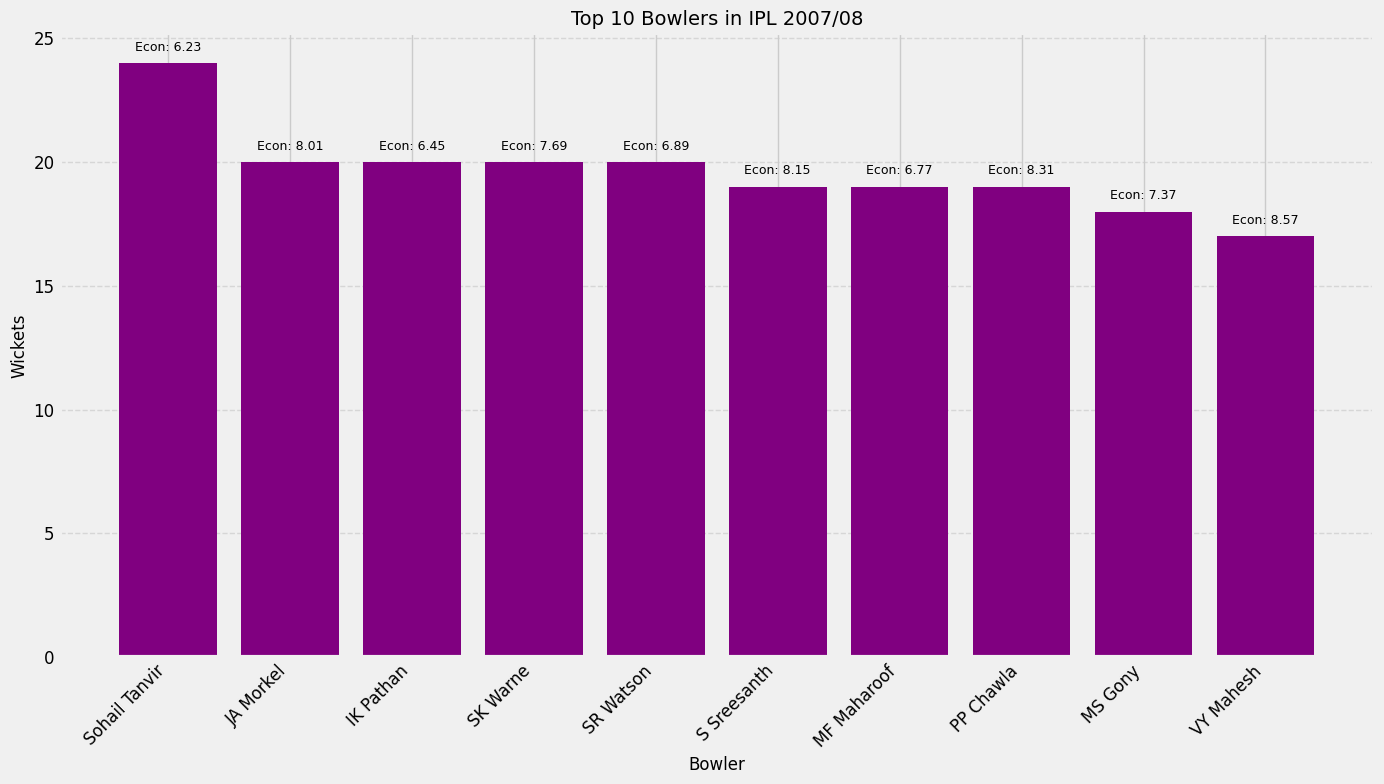


Top 10 Bowlers for IPL 2009:
      bowler  wickets  economy  average
67  RP Singh       26     6.75    16.54
3    A Nehra       22     6.52    16.09
1   A Kumble       22     5.92    16.05


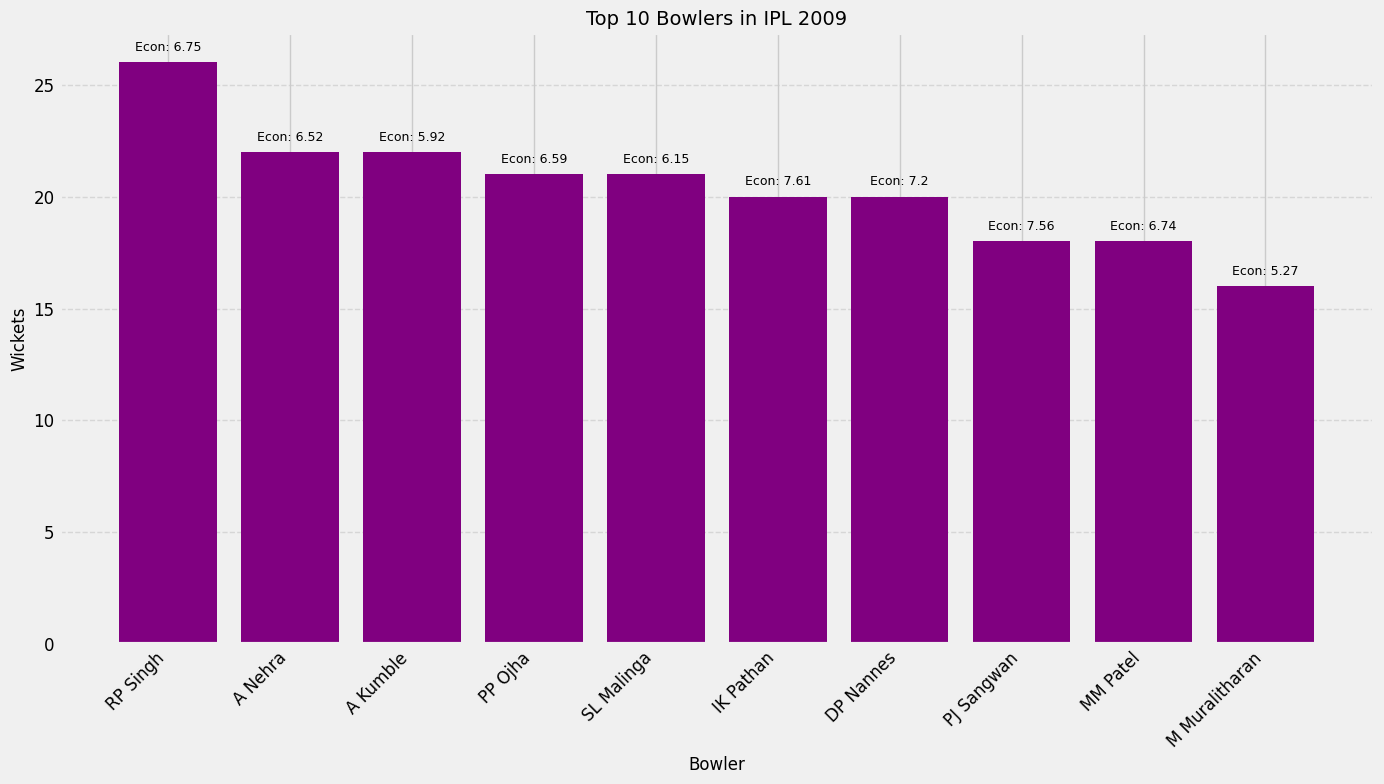


Top 10 Bowlers for IPL 2009/10:
             bowler  wickets  economy  average
61          PP Ojha       22     7.32    19.95
1          A Mishra       20     6.77    18.55
28  Harbhajan Singh       20     6.92    19.25


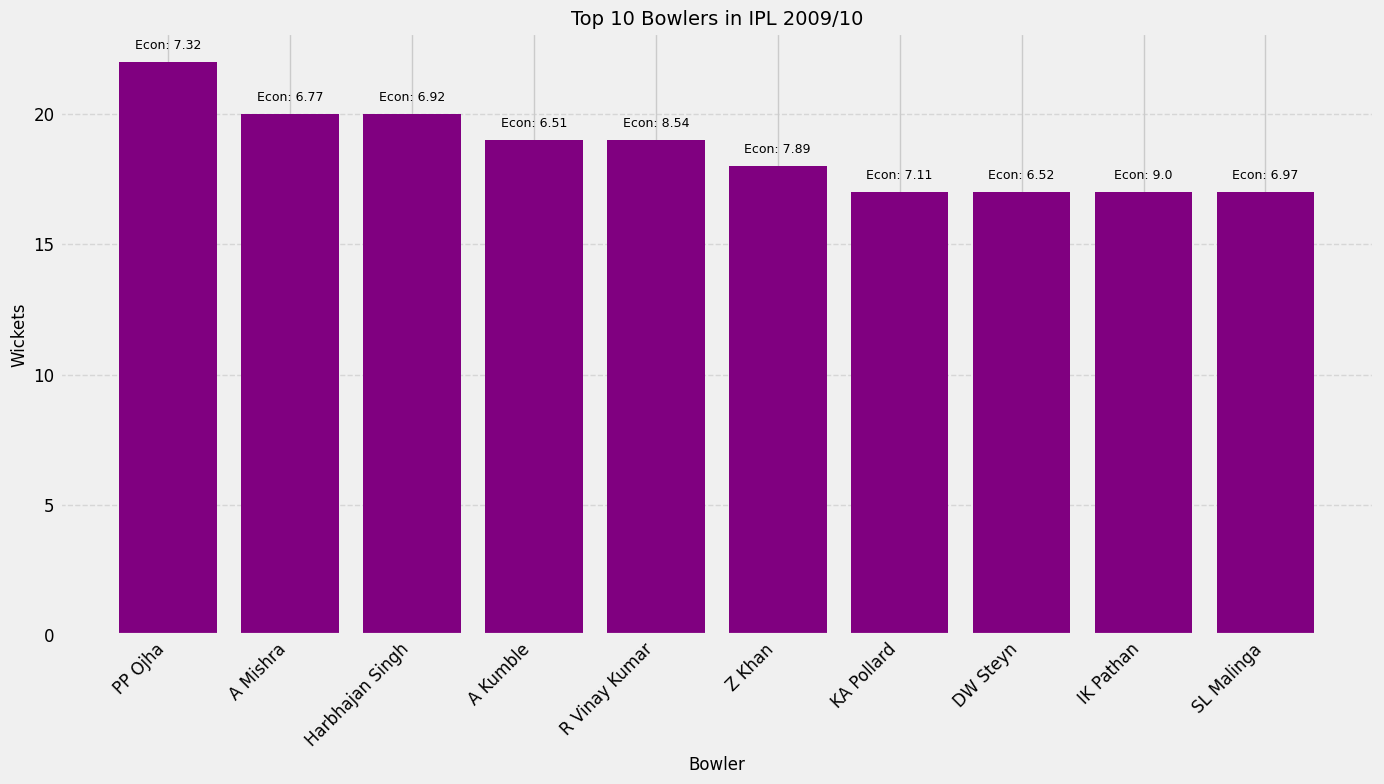


Top 10 Bowlers for IPL 2011:
        bowler  wickets  economy  average
86  SL Malinga       30     5.94    13.10
53    MM Patel       22     6.88    17.14
75   S Aravind       22     7.85    17.14


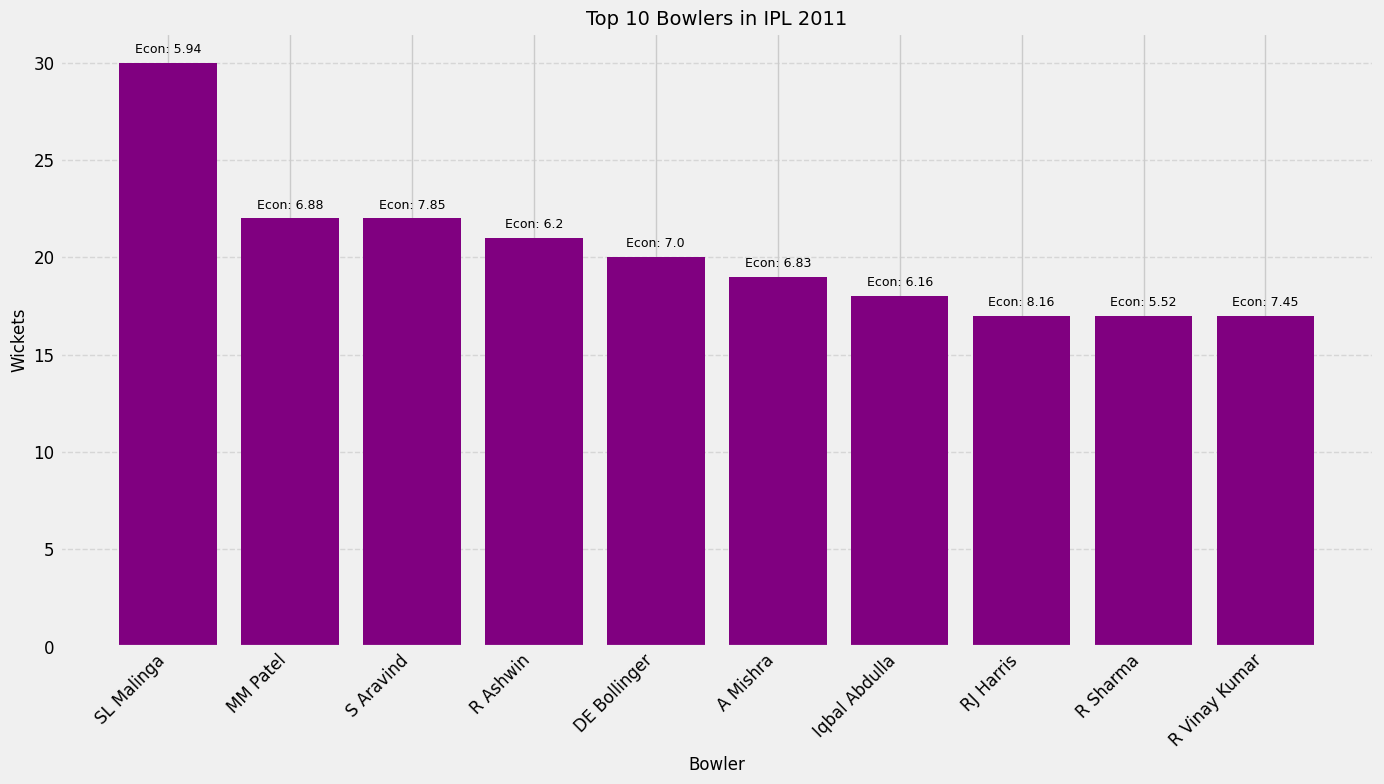


Top 10 Bowlers for IPL 2012:
        bowler  wickets  economy  average
57    M Morkel       30     7.19    15.53
89   SP Narine       29     5.58    11.45
88  SL Malinga       25     6.07    14.20


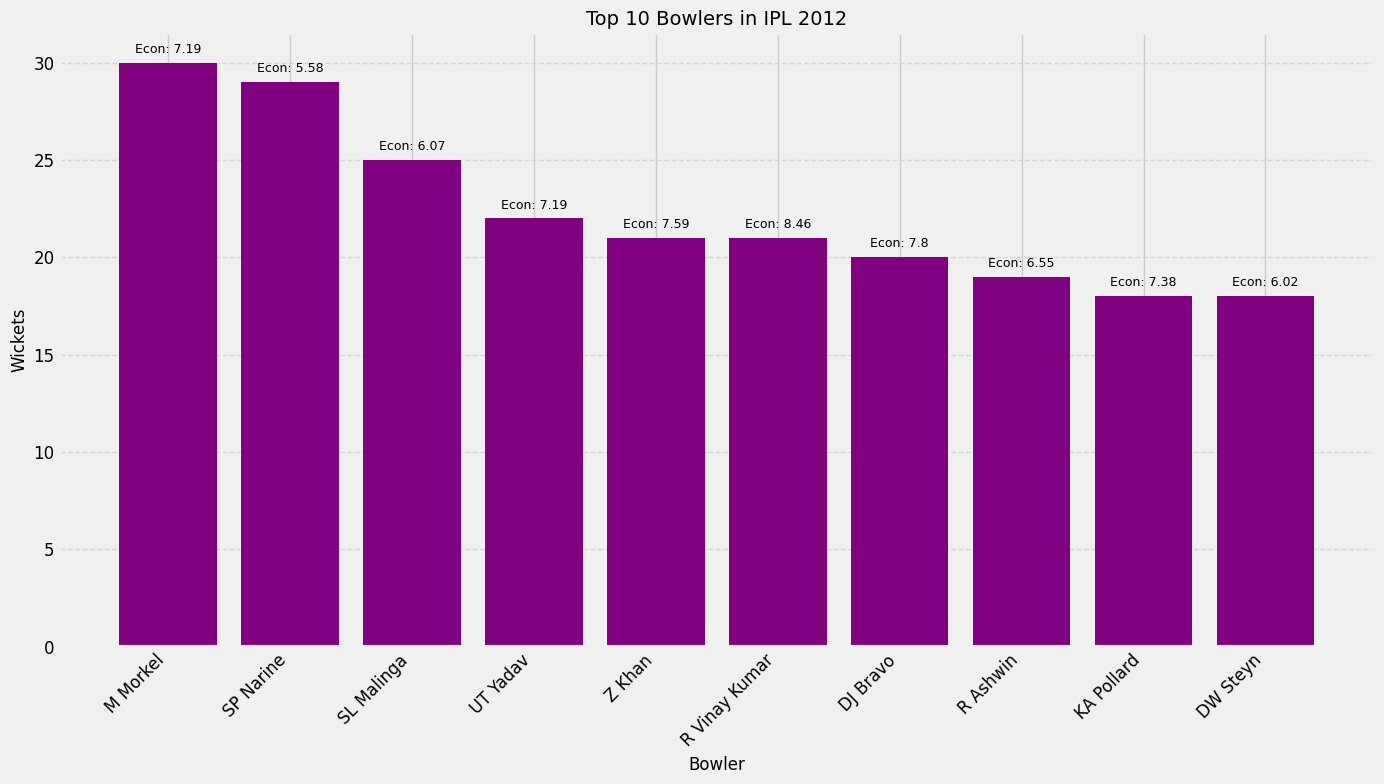


Top 10 Bowlers for IPL 2013:
           bowler  wickets  economy  average
27       DJ Bravo       34     7.73    14.85
47    JP Faulkner       33     6.62    13.21
83  R Vinay Kumar       27     8.31    19.33


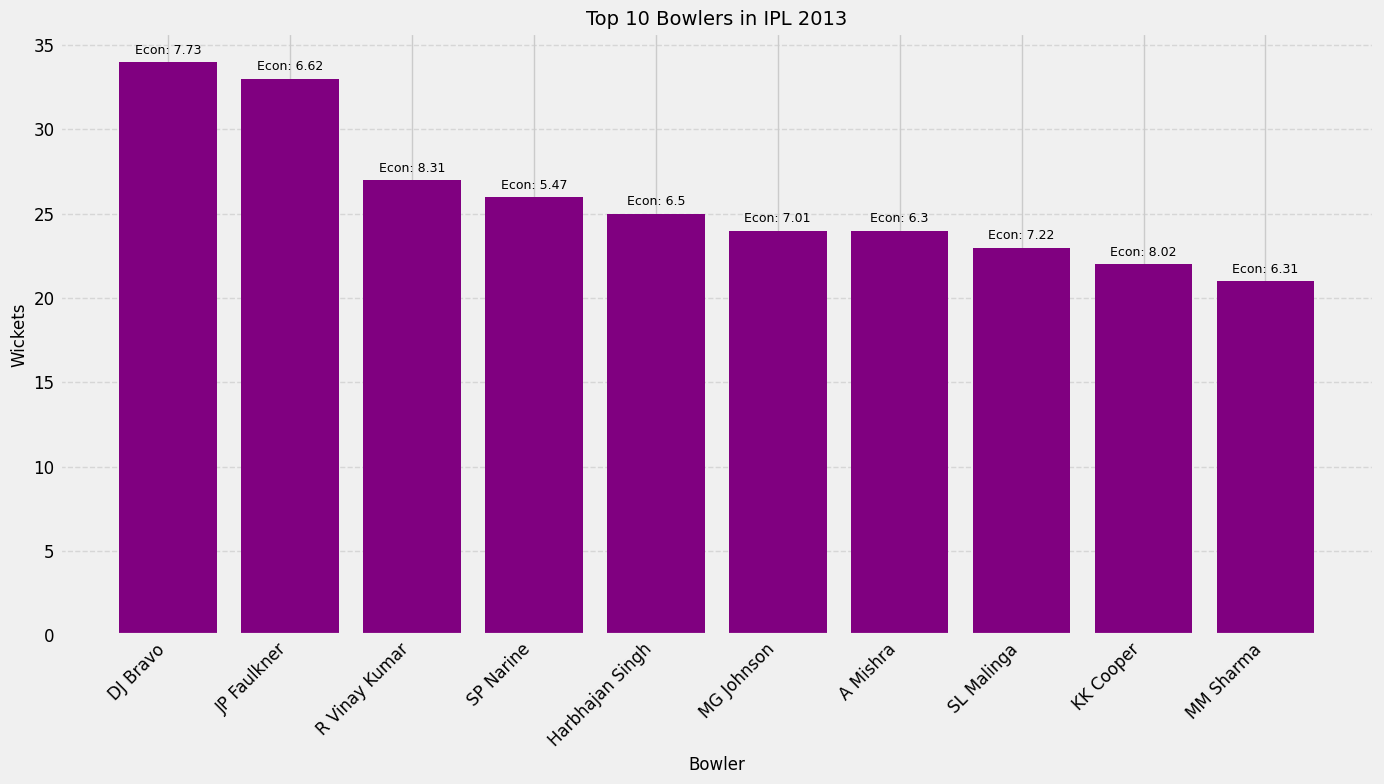


Top 10 Bowlers for IPL 2014:
       bowler  wickets  economy  average
49  MM Sharma       26     8.46    17.58
78  SP Narine       22     6.61    19.64
7     B Kumar       21     6.64    17.24


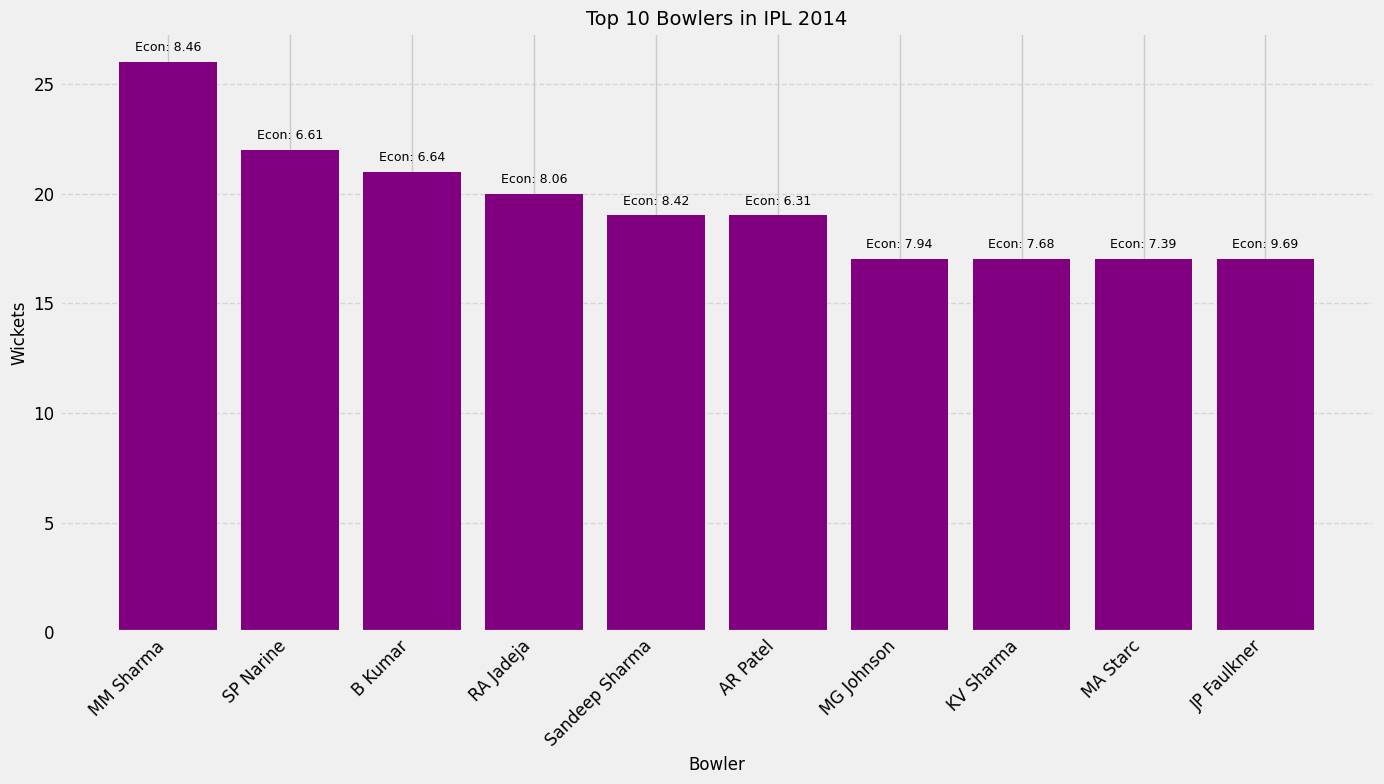


Top 10 Bowlers for IPL 2015:
        bowler  wickets  economy  average
16    DJ Bravo       28     8.19    15.79
71  SL Malinga       26     7.19    17.42
2      A Nehra       25     7.06    18.12


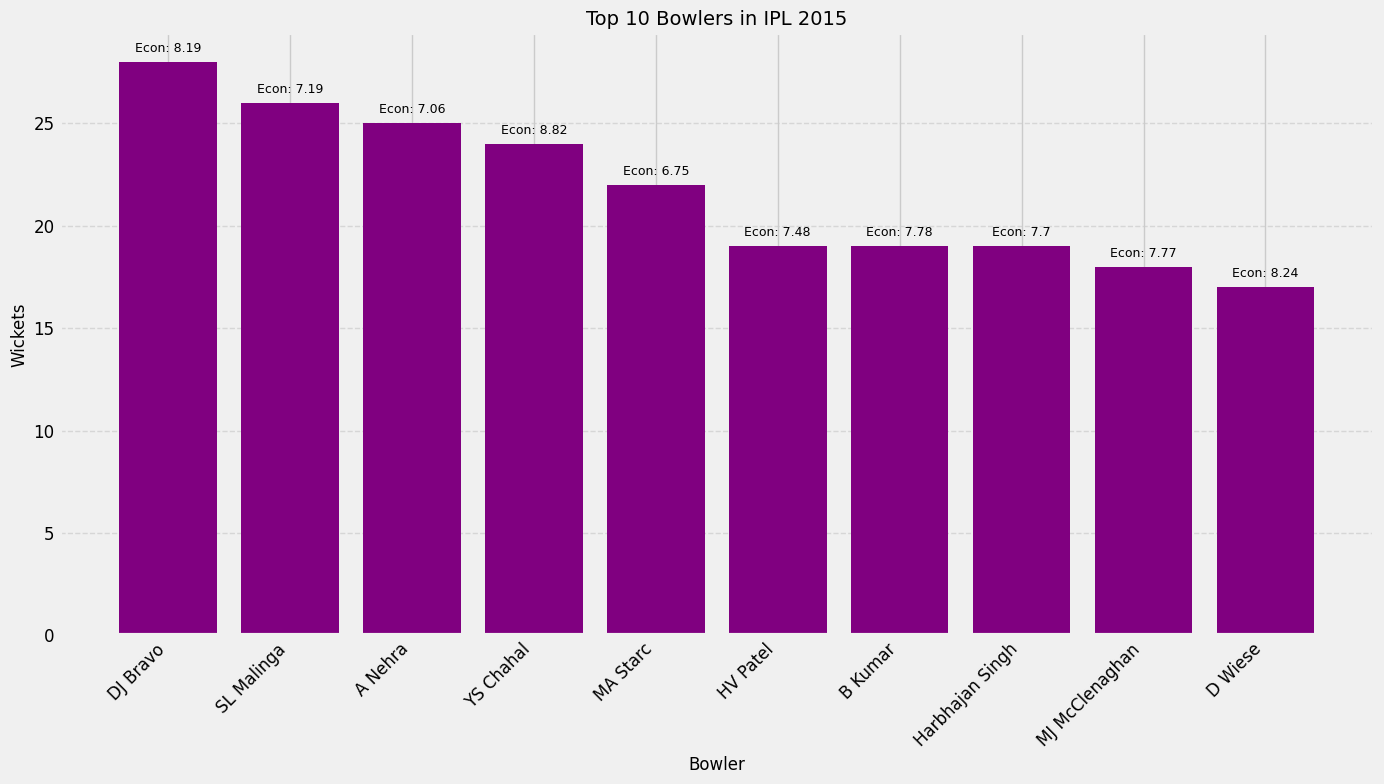


Top 10 Bowlers for IPL 2016:
       bowler  wickets  economy  average
11    B Kumar       24     7.29    20.96
75  SR Watson       23     8.17    21.30
86  YS Chahal       22     7.97    18.59


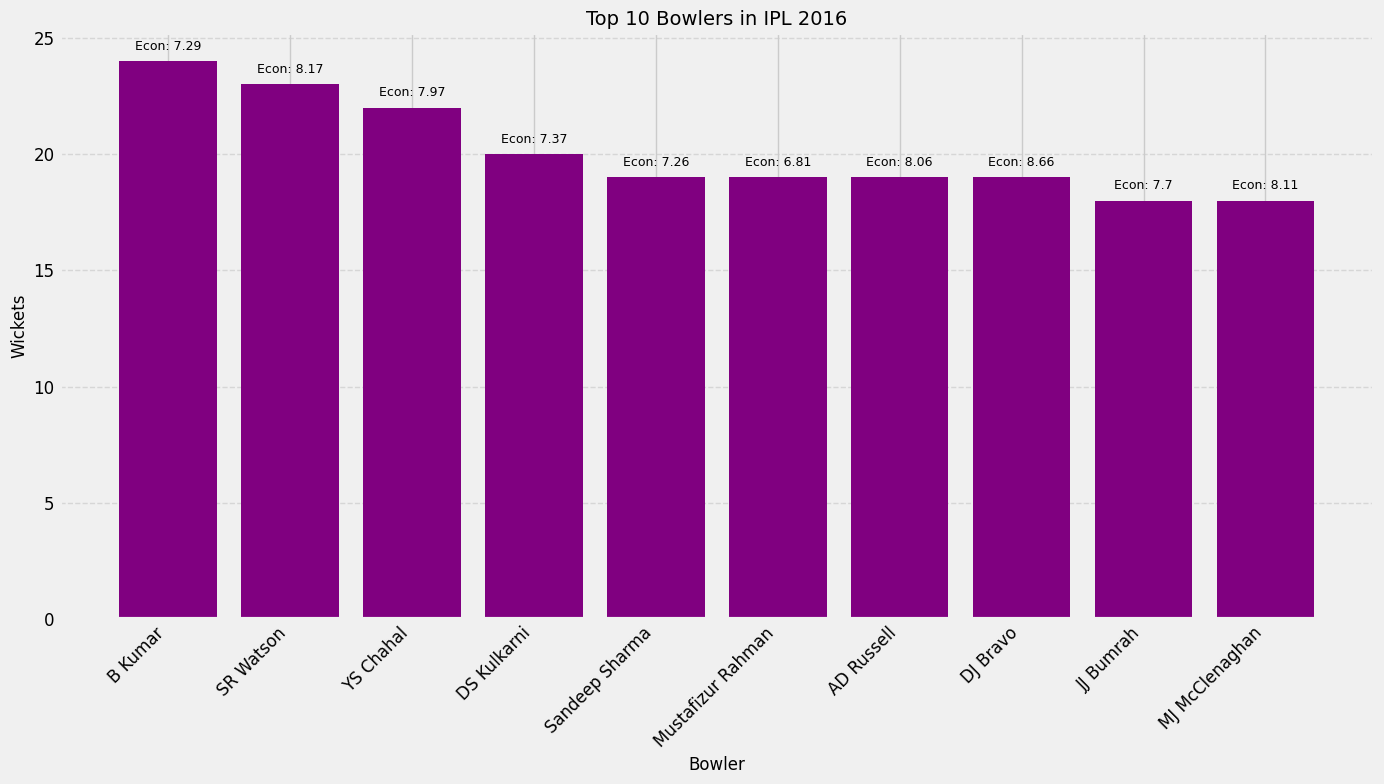


Top 10 Bowlers for IPL 2017:
        bowler  wickets  economy  average
11     B Kumar       28     7.11    13.71
35  JD Unadkat       27     7.10    12.22
36   JJ Bumrah       23     7.32    19.78


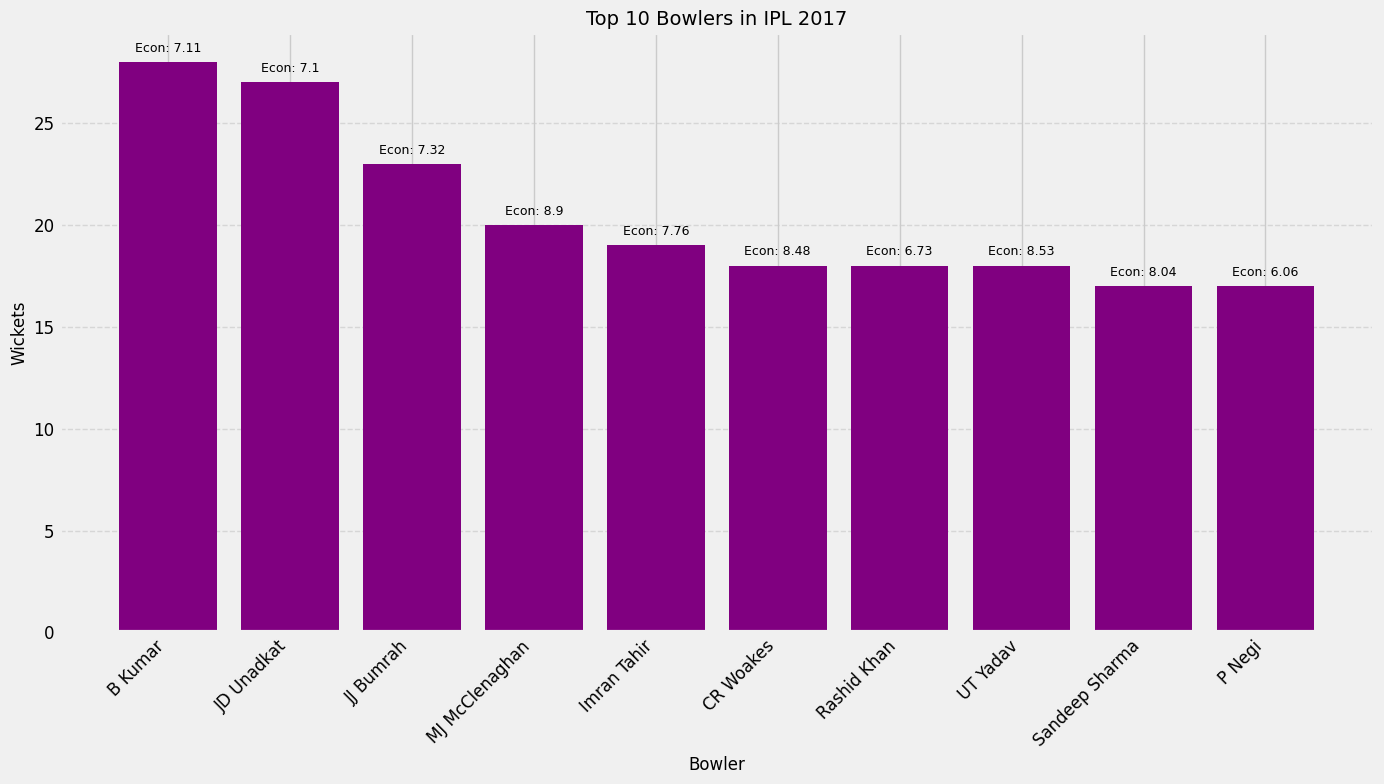


Top 10 Bowlers for IPL 2018:
         bowler  wickets  economy  average
2        AJ Tye       28     7.80    16.39
65       S Kaul       24     8.33    23.25
63  Rashid Khan       23     6.80    20.26


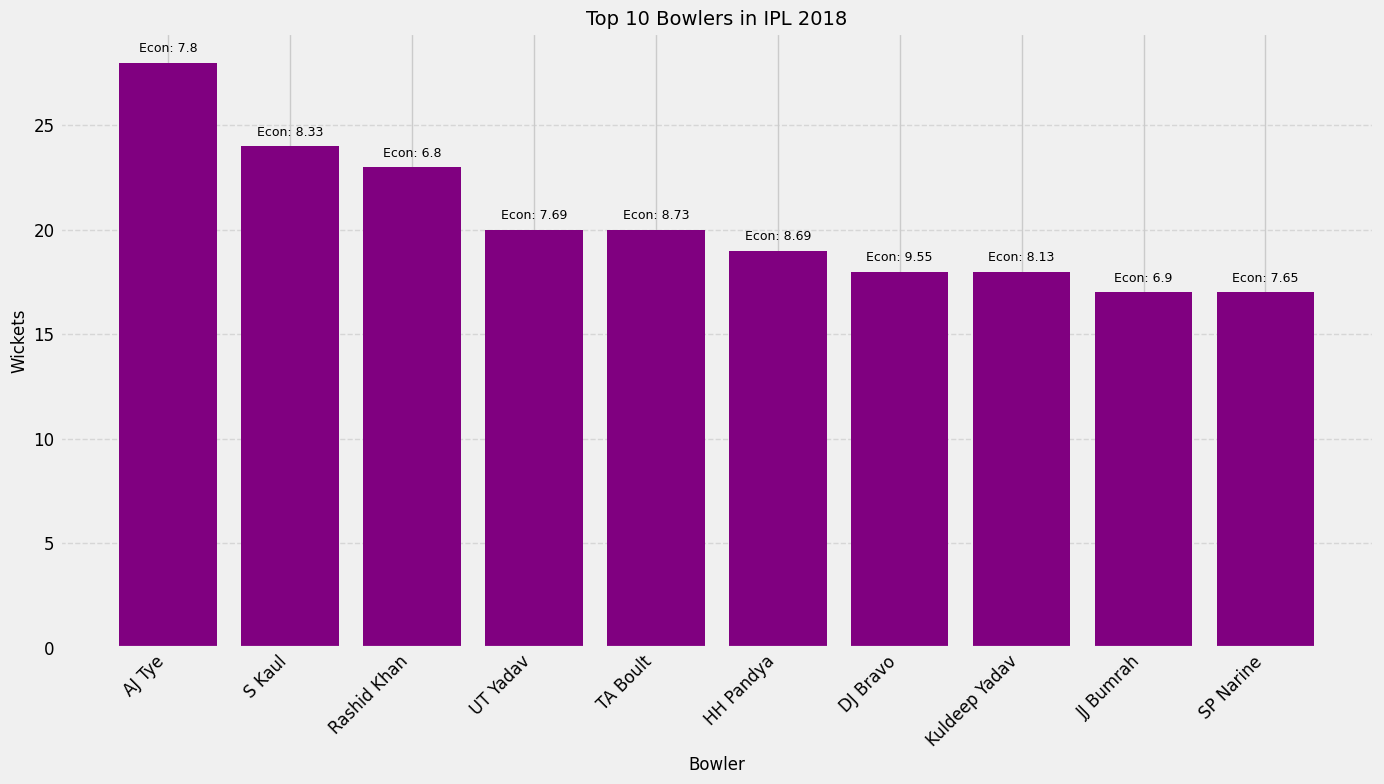


Top 10 Bowlers for IPL 2019:
         bowler  wickets  economy  average
35     K Rabada       29     7.69    13.17
26  Imran Tahir       26     6.80    16.92
31    JJ Bumrah       23     6.80    18.83


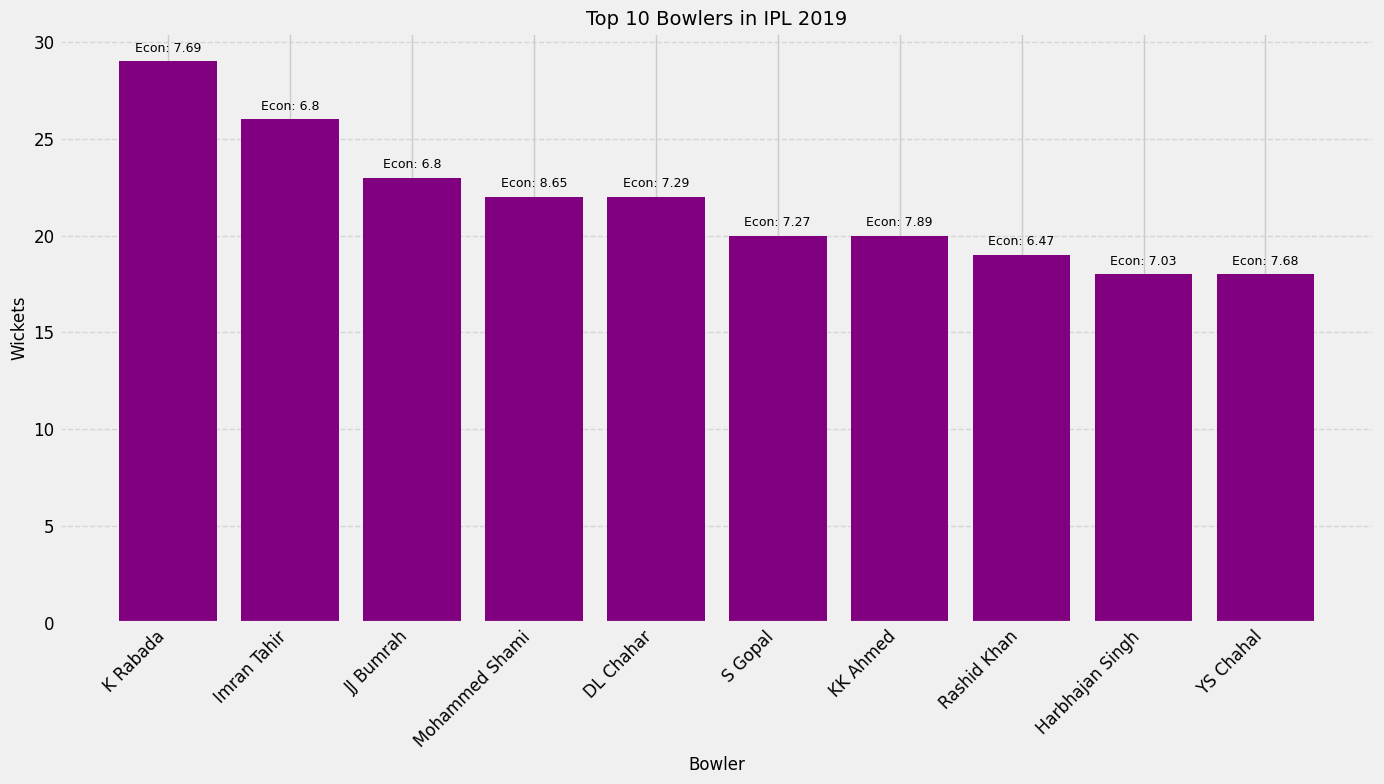


Top 10 Bowlers for IPL 2020/21:
       bowler  wickets  economy  average
32   K Rabada       32     8.19    17.66
27  JJ Bumrah       30     6.81    14.53
72   TA Boult       26     8.02    18.19


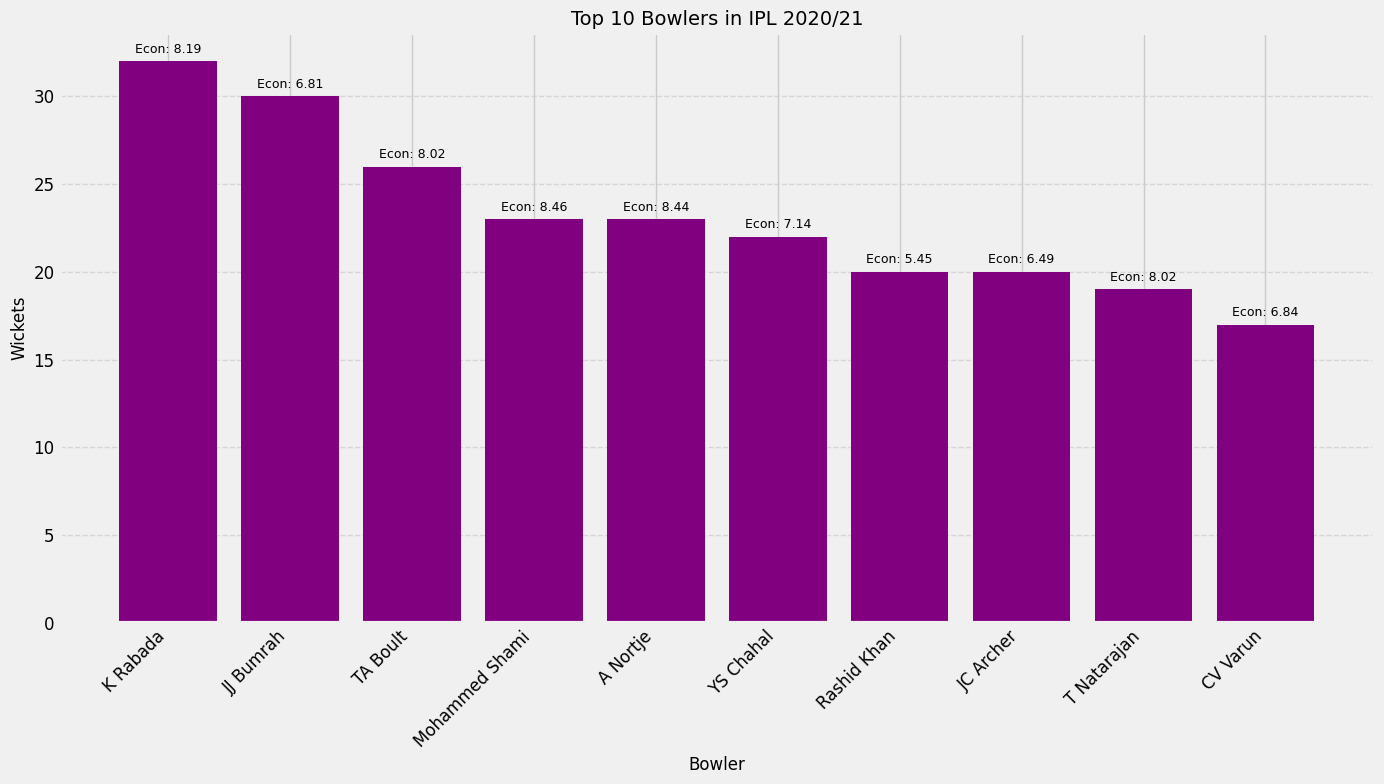


Top 10 Bowlers for IPL 2021:
        bowler  wickets  economy  average
24    HV Patel       35     7.66    13.17
8   Avesh Khan       27     7.30    17.26
34   JJ Bumrah       22     7.30    19.18


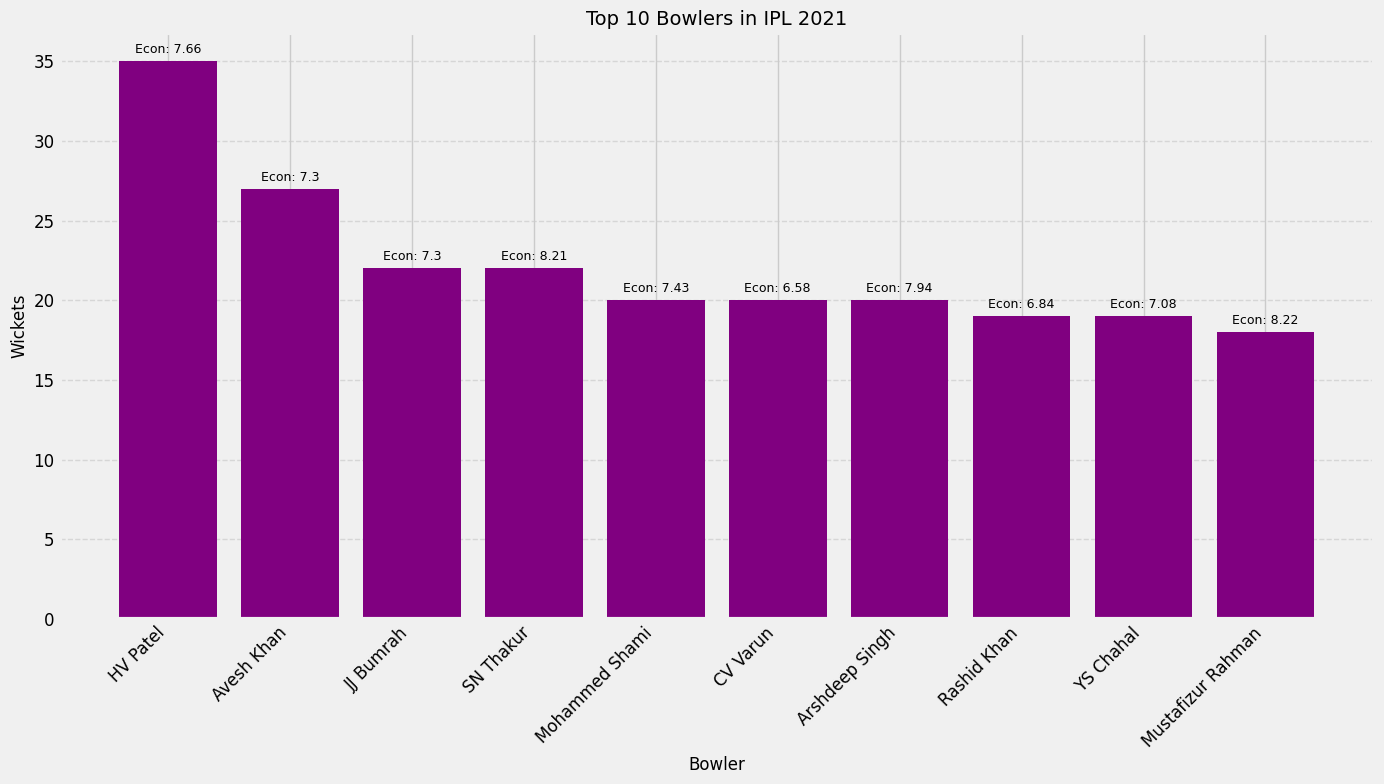


Top 10 Bowlers for IPL 2022:
           bowler  wickets  economy  average
103     YS Chahal       29     7.50    18.48
71   PWH de Silva       27     7.61    16.26
98    Umran Malik       23     8.72    19.78


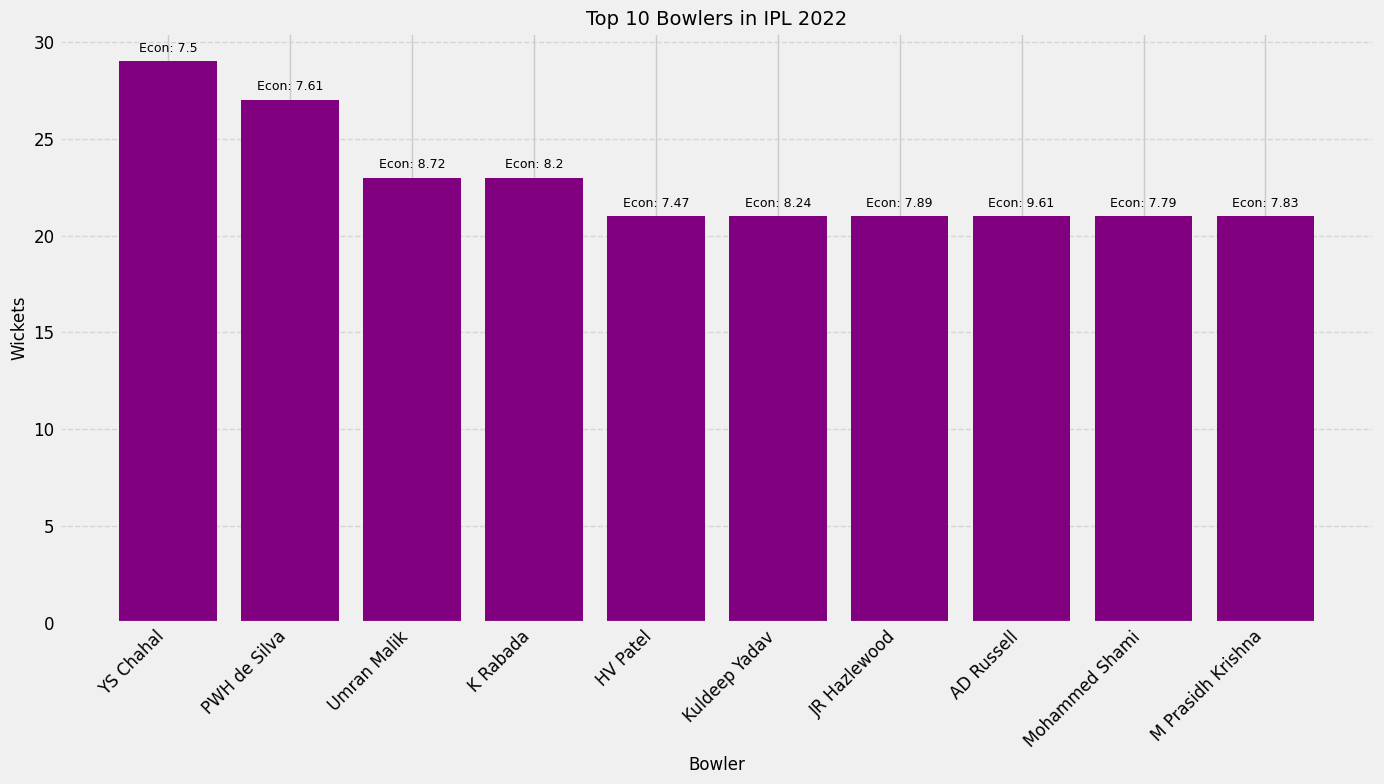


Top 10 Bowlers for IPL 2023:
            bowler  wickets  economy  average
65       MM Sharma       31     8.10    11.68
69  Mohammed Shami       28     7.92    19.00
90     Rashid Khan       28     8.21    19.89


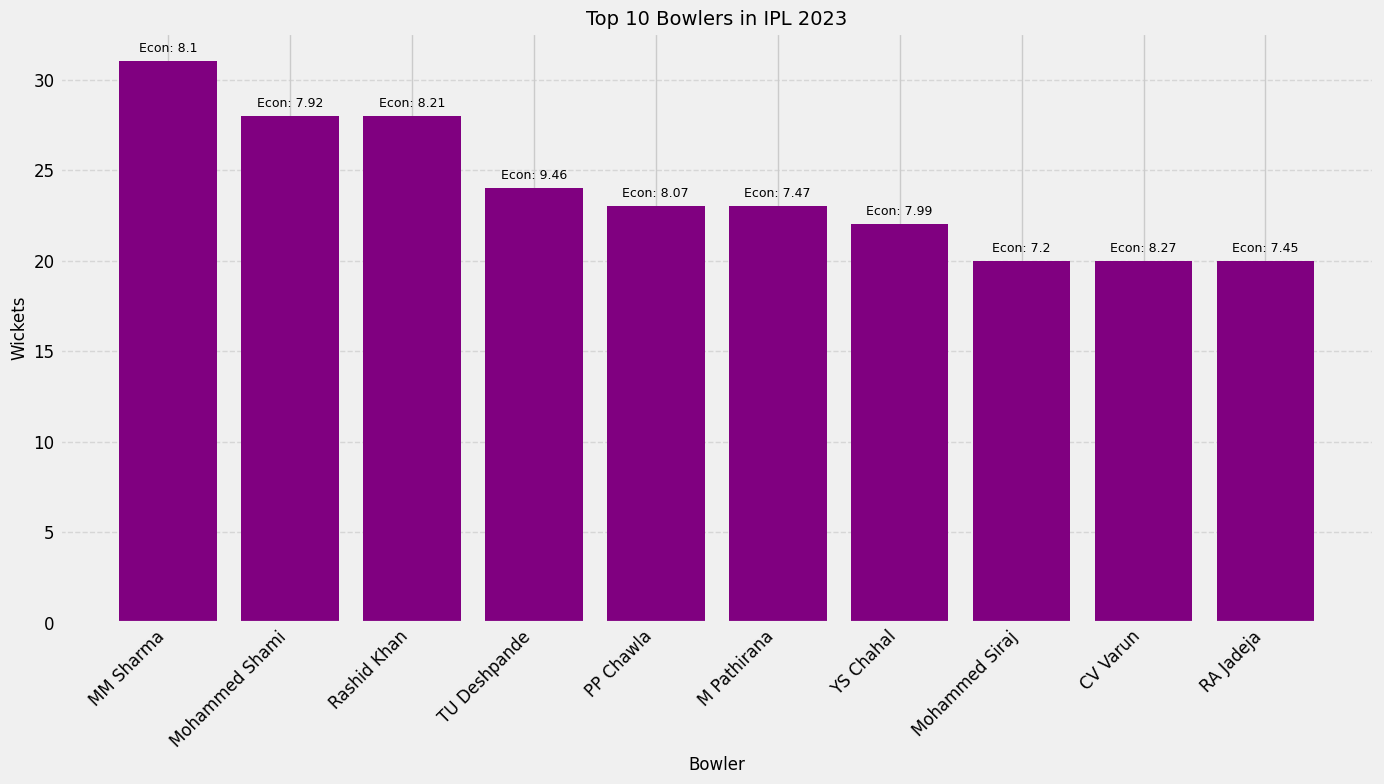


Top 10 Bowlers for IPL 2024:
          bowler  wickets  economy  average
23      HV Patel       30     9.18    16.17
12    Avesh Khan       22     9.24    24.23
59  Mukesh Kumar       22    10.20    17.23


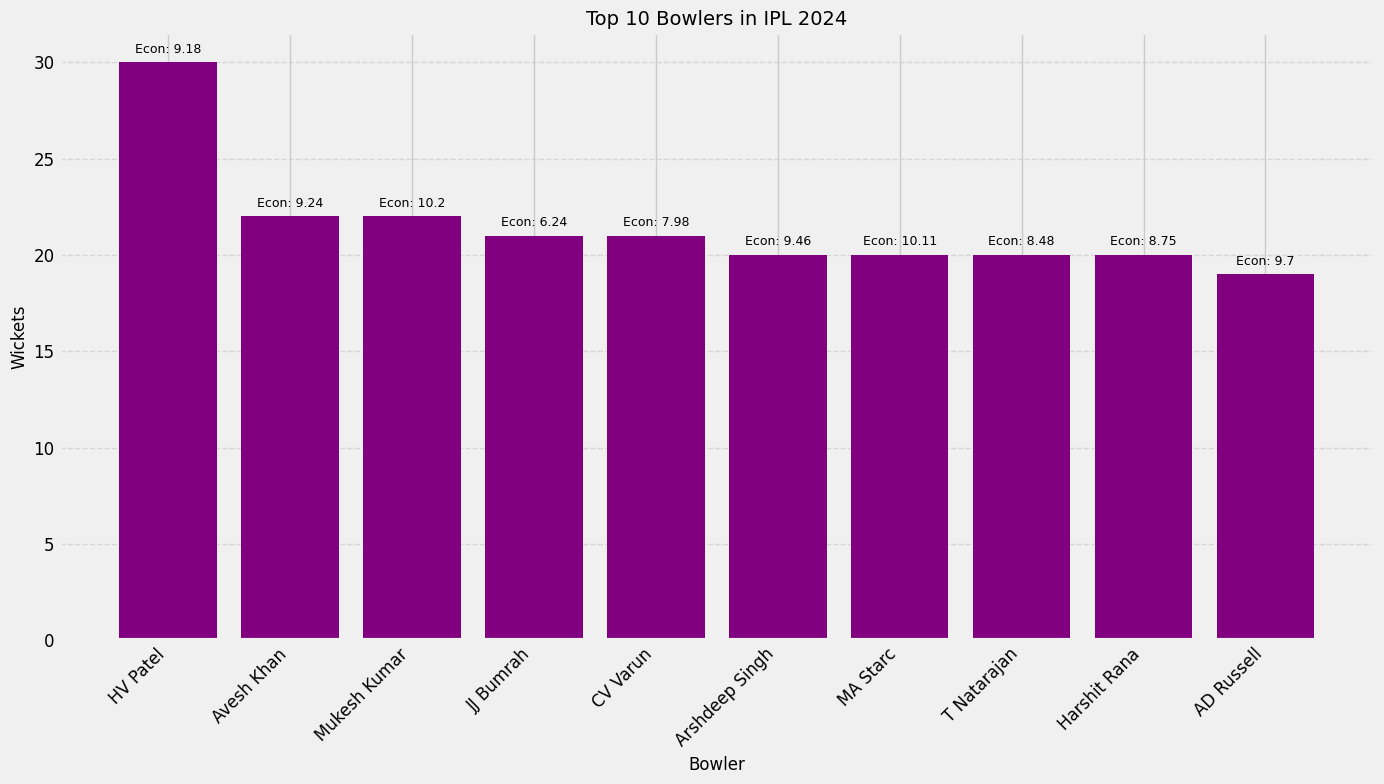

In [56]:

# Get and plot top bowlers for each season
print("\nAnalyzing top bowlers for each season...")
all_top_bowlers = analyze_top_bowlers_all_seasons(deliveries, matches)
for season, top_bowlers in all_top_bowlers.items():
    print(f"\nTop 10 Bowlers for IPL {season}:")
    print(top_bowlers[['bowler', 'wickets', 'economy', 'average']].head(3))  # Print only top 3 for brevity
    plot_top_bowlers(top_bowlers, season)


In [57]:

# ------------------ SECTION 6: PLAYER CLUSTERING ANALYSIS ------------------

print("\n" + "="*30 + " PLAYER CLUSTERING ANALYSIS " + "="*30)

# 6.1 Prepare Data for Clustering
# Get players with sufficient data (more than 100 balls faced)
ball_faced = deliveries.groupby('batter')['ball'].count() 
ball_face_batsman = ball_faced[ball_faced > 100].reset_index().sort_values(by='batter').rename(columns={'ball':'ball_faced'})

print(f"\nNumber of qualified batsmen (>100 balls faced): {len(ball_face_batsman)}")

# Get batting stats for qualified batsmen
correct_batsmen = deliveries[deliveries['batter'].isin(ball_face_batsman['batter'])]
total_runs = correct_batsmen.groupby('batter')['batsman_runs'].sum().reset_index().sort_values(by='batter')
batter_out = correct_batsmen[correct_batsmen['is_wicket'] == 1]['batter'].value_counts().reset_index().sort_values(by='batter').rename(columns={'count':'num_times_out'})

# Merge all stats
merge = (ball_face_batsman
         .merge(total_runs, on='batter', how='inner')
         .merge(batter_out, on='batter', how='inner'))

# Calculate batting average and strike rate
merge['batting_avg'] = merge['batsman_runs'] / merge['num_times_out']
merge['strike_rate'] = (merge['batsman_runs'] / merge['ball_faced']) * 100



============================== PLAYER CLUSTERING ANALYSIS ==============================

Number of qualified batsmen (>100 balls faced): 299


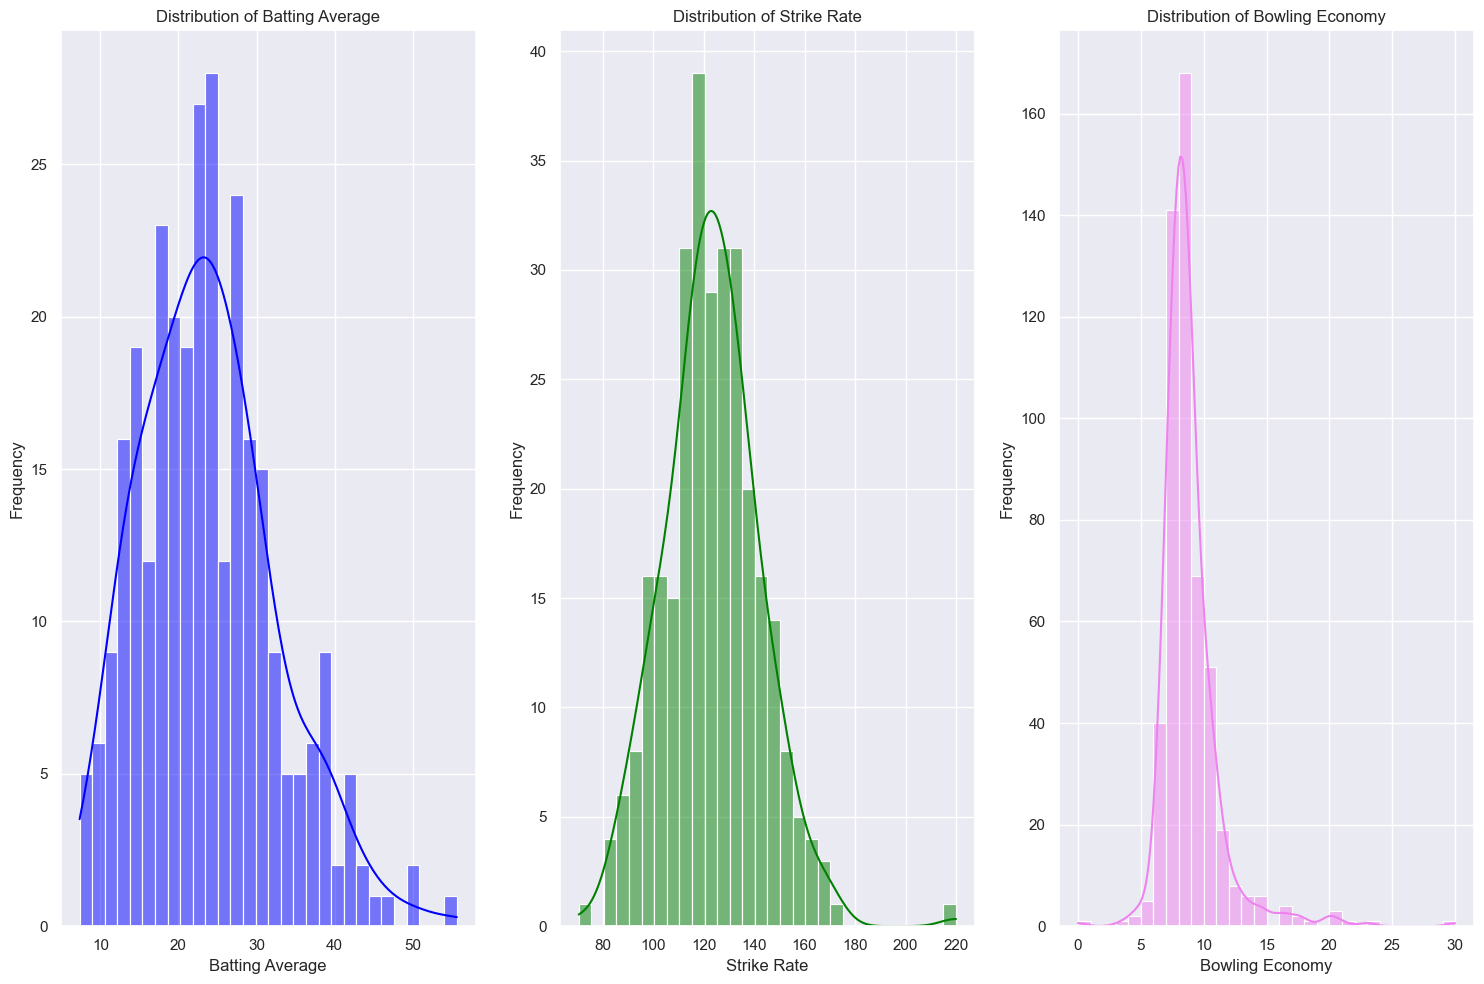

In [58]:

# 6.2 Visualize Batting Stats Distribution
# Set plot style for distribution plots
sns.set_theme(style="darkgrid")

# Create subplots for Batting Average and Strike Rate distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

# Batting Average Distribution
sns.histplot(data=merge, x="batting_avg", bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Distribution of Batting Average")
ax[0].set_xlabel("Batting Average")
ax[0].set_ylabel("Frequency")

# Strike Rate Distribution
sns.histplot(data=merge, x="strike_rate", bins=30, kde=True, ax=ax[1], color="green")
ax[1].set_title("Distribution of Strike Rate")
ax[1].set_xlabel("Strike Rate")
ax[1].set_ylabel("Frequency")

# Bowling Economy Distribution
sns.histplot(data=merged_df, x="bowling_eco", bins=30, kde=True, ax=ax[2], color="violet")
ax[2].set_title("Distribution of Bowling Economy")
ax[2].set_xlabel("Bowling Economy")
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('stat_distributions.png')
plt.show()


In [59]:

# 6.3 Remove Outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25%)
    Q3 = df[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply function to remove outliers from batting_avg and strike_rate
filtered_df = remove_outliers(merge, 'batting_avg')
filtered_df = remove_outliers(filtered_df, 'strike_rate')

print(f"\nNumber of batsmen after removing outliers: {len(filtered_df)}")
print("\nBatsmen with average > 40 after filtering:")
print(filtered_df[filtered_df['batting_avg'] > 40]['batter'].tolist())



Number of batsmen after removing outliers: 289

Batsmen with average > 40 after filtering:
['AB de Villiers', 'DA Warner', 'HM Amla', 'JP Duminy', 'KL Rahul', 'RD Gaikwad', 'Tilak Varma']


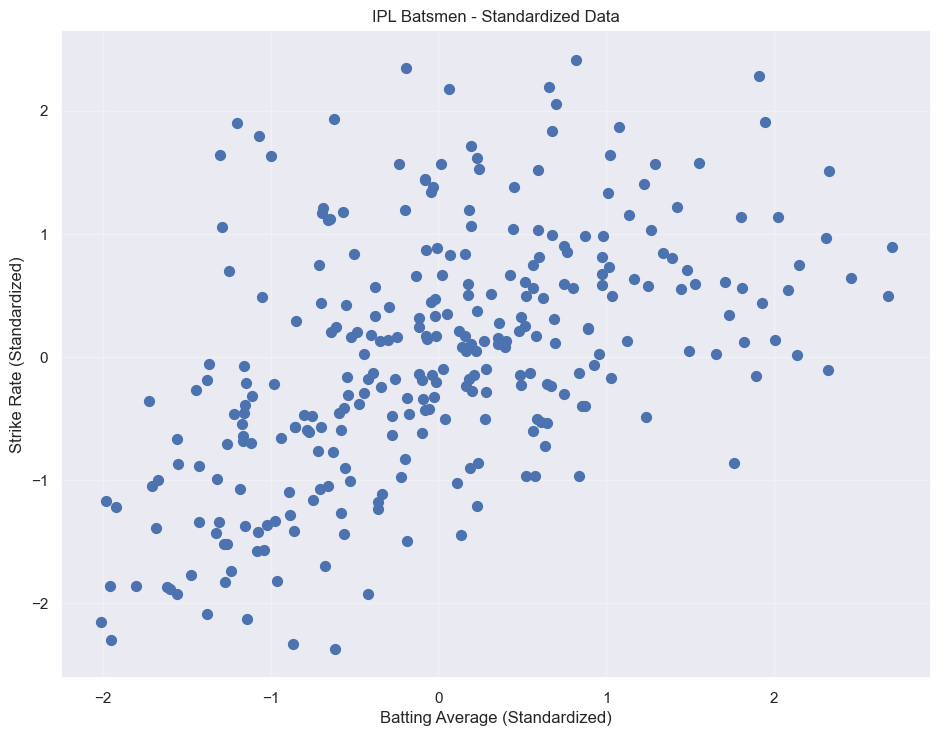

In [60]:

# 6.4 Perform K-Means Clustering
# Prepare data for clustering
X = filtered_df.iloc[:, 4:6].values  # batting_avg and strike_rate columns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Plot the standardized data
plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=50, cmap='viridis')
plt.title("IPL Batsmen - Standardized Data")
plt.xlabel("Batting Average (Standardized)")
plt.ylabel("Strike Rate (Standardized)")
plt.grid(True, alpha=0.3)
plt.savefig('standardized_data.png')
plt.show()


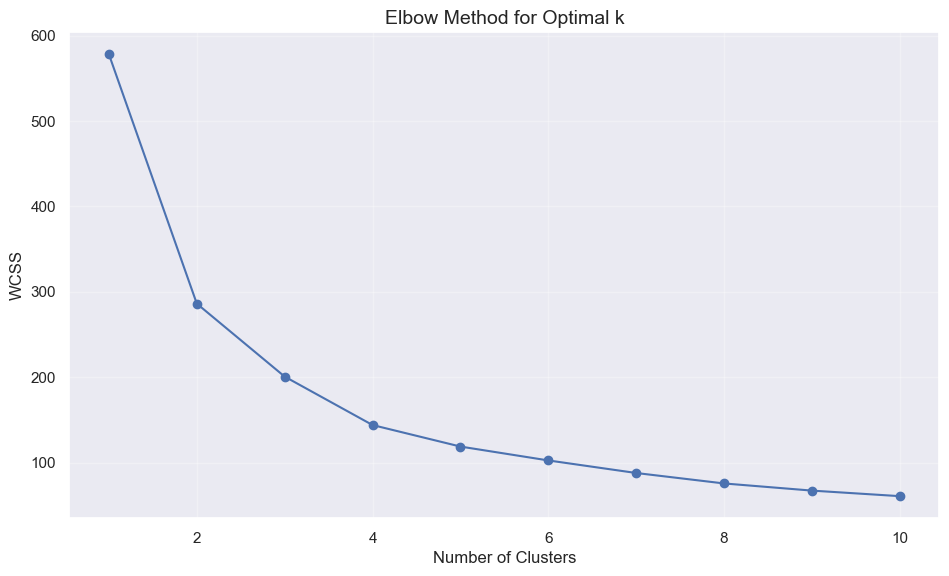

In [61]:

# Find optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_init=10, n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('elbow_method.png')
plt.show()



Silhouette Scores for different numbers of clusters:
For k=2, Silhouette Score: 0.4209473995159839
For k=3, Silhouette Score: 0.3686234547601063
For k=4, Silhouette Score: 0.39581384783085605
For k=5, Silhouette Score: 0.3583373579528638
For k=6, Silhouette Score: 0.3452141024919769
For k=7, Silhouette Score: 0.33953196419725357
For k=8, Silhouette Score: 0.35063000786322396
For k=9, Silhouette Score: 0.3607907241872265
For k=10, Silhouette Score: 0.35078686403234766


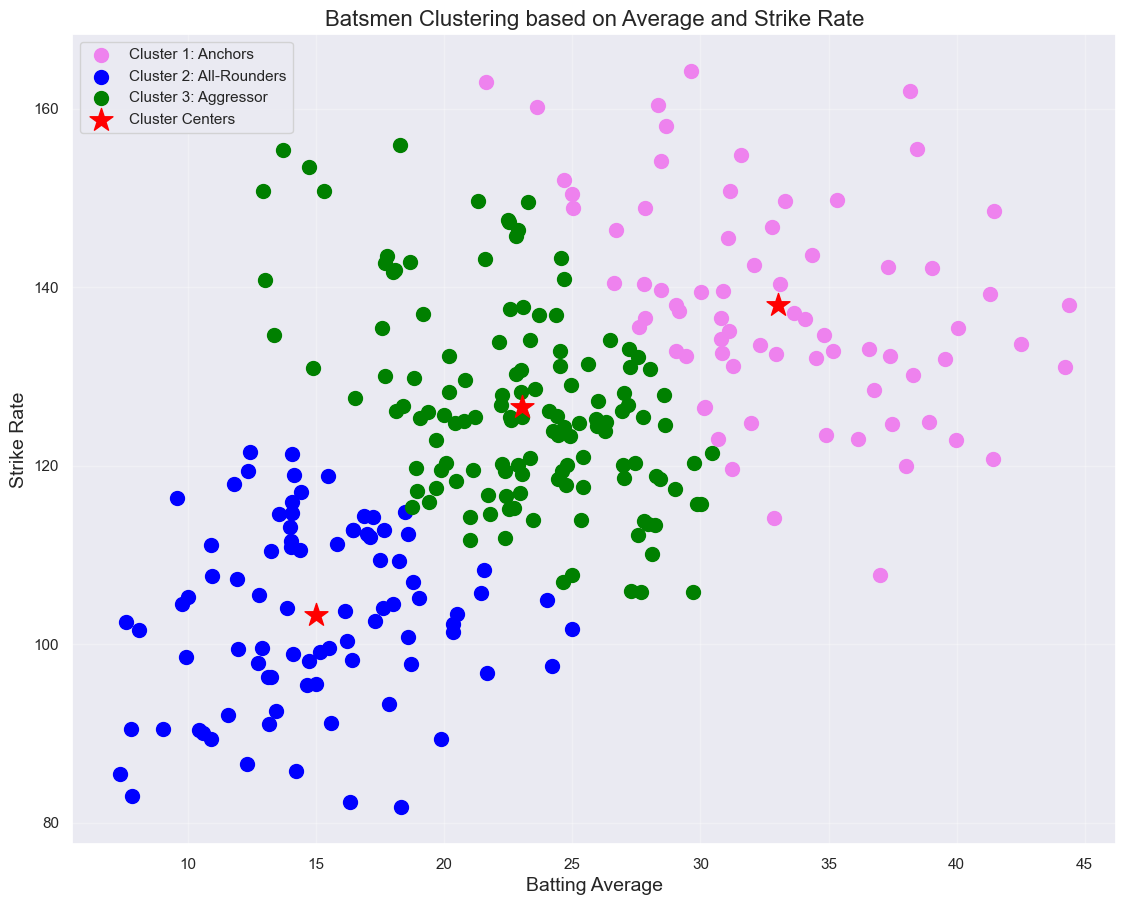

In [63]:

from sklearn.metrics import silhouette_score

# Validate using Silhouette Score
print("\nSilhouette Scores for different numbers of clusters:")
for i in range(2, 11):  # Start from 2 instead of 1
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'For k={i}, Silhouette Score: {score}')

# Based on Elbow Method and Silhouette Score, choose k=3
kmeans = KMeans(n_init=10, n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(12, 10))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='violet', label='Cluster 1: Anchors')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2: All-Rounders')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3: Aggressor')

# Plot cluster centers
centers = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='*', label='Cluster Centers')

plt.title('Batsmen Clustering based on Average and Strike Rate', fontsize=16)
plt.xlabel('Batting Average', fontsize=14)
plt.ylabel('Strike Rate', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('batsmen_clusters.png')
plt.show()



Sample batsmen from each cluster:

Cluster 0 - Sample Batsmen:
            batter  batting_avg  strike_rate
5        A Symonds    37.461538   124.711908
9   AB de Villiers    41.448000   148.580442
11        AC Voges    30.166667   126.573427
14      AD Russell    29.619048   164.224422
16      AK Markram    30.151515   126.429479

Cluster 1 - Sample Batsmen:
             batter  batting_avg  strike_rate
3          A Mishra    12.290323    86.590909
6   AA Jhunjhunwala    15.500000    99.541284
17       AL Menaria    18.227273   109.264305
18         AM Nayar    17.230769   114.285714
20          AP Tare    14.125000   118.947368

Cluster 2 - Sample Batsmen:
           batter  batting_avg  strike_rate
0  A Ashish Reddy    18.666667   142.857143
1        A Badoni    24.384615   125.544554
2       A Manohar    16.500000   127.624309
4   A Raghuvanshi    23.285714   149.541284
7      AB Agarkar    22.375000   111.875000


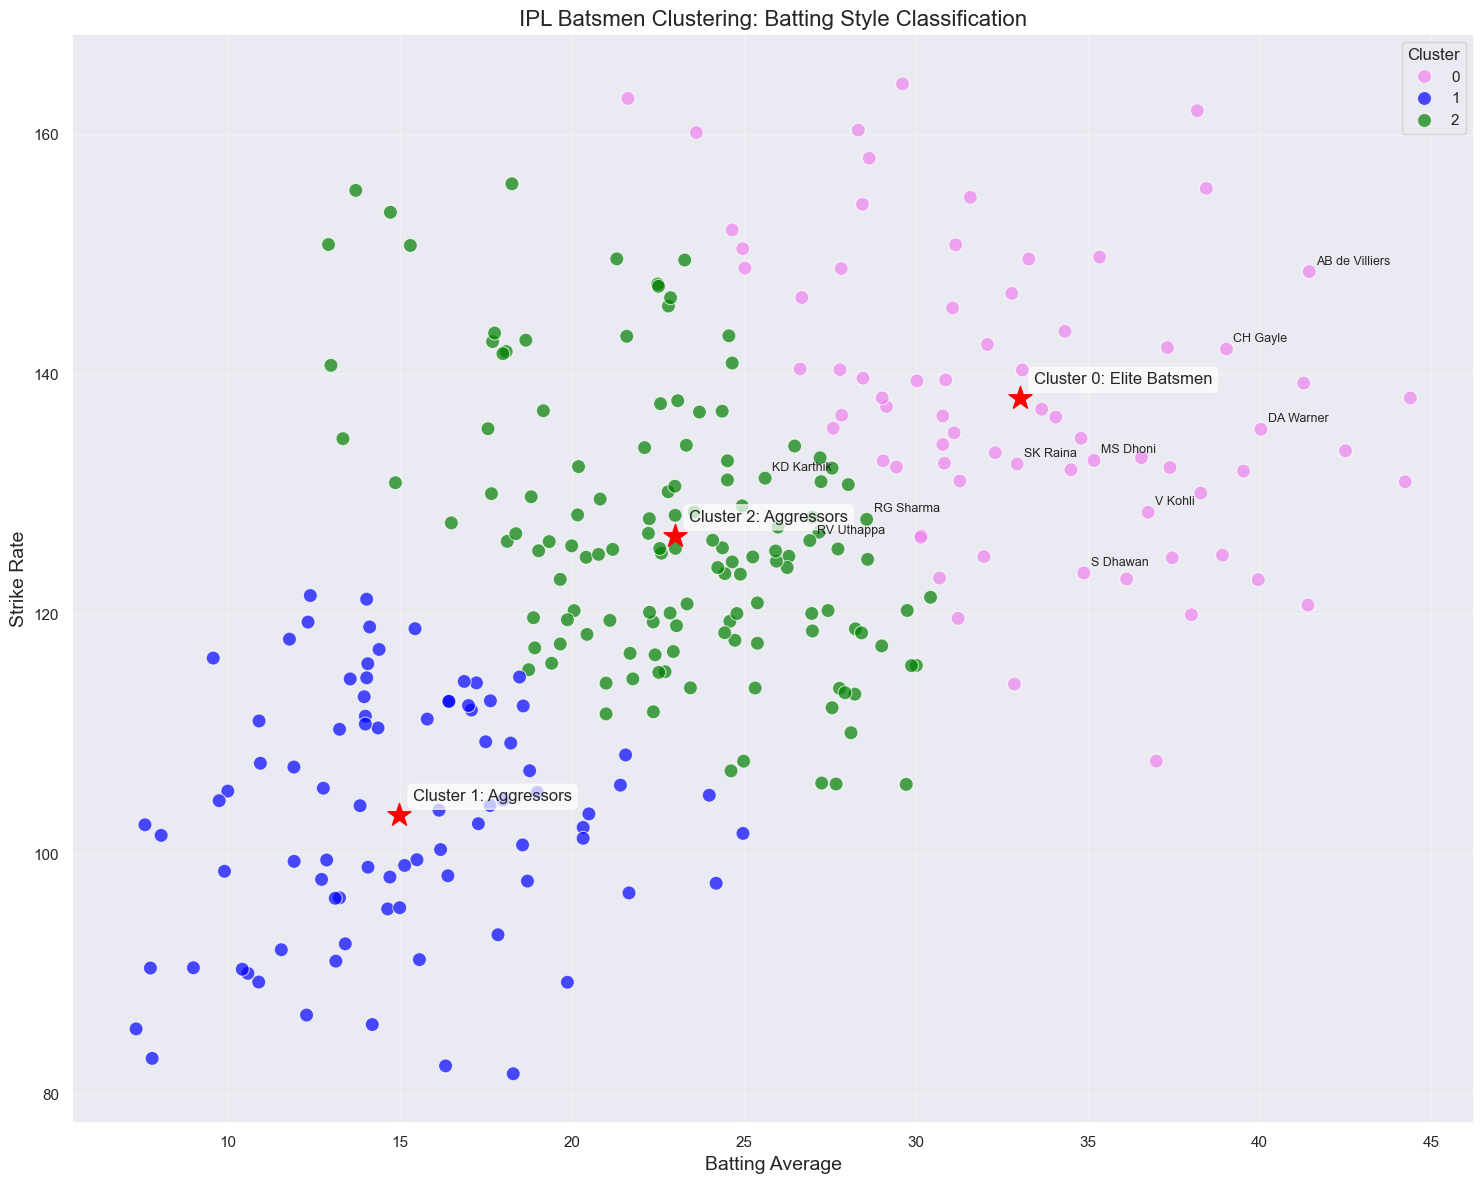

In [64]:

# Add cluster labels to the dataframe
filtered_df['Cluster'] = y_kmeans

# Display samples from each cluster
print("\nSample batsmen from each cluster:")
for cluster in range(3):
    print(f"\nCluster {cluster} - Sample Batsmen:")
    cluster_sample = filtered_df[filtered_df['Cluster'] == cluster].head(5)
    print(cluster_sample[['batter', 'batting_avg', 'strike_rate']])

# Create a better visualization with cluster interpretations
# Create a nicer scatter plot with batsmen names
plt.figure(figsize=(15, 12))
sns.scatterplot(
    data=filtered_df, 
    x='batting_avg', 
    y='strike_rate', 
    hue='Cluster',
    palette=['violet', 'blue', 'green'],
    s=100, alpha=0.7
)

# Plot cluster centers with annotations
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], s=300, c='red', marker='*')
    
    # Determine cluster type based on average and strike rate
    if center[0] > 30 and center[1] > 130:
        cluster_type = "Elite Batsmen"
    elif center[0] > 25 and center[1] < 130:
        cluster_type = "Anchors"
    else:
        cluster_type = "Aggressors"
        
    plt.annotate(f"Cluster {i}: {cluster_type}", 
                xy=(center[0], center[1]), 
                xytext=(10, 10), 
                textcoords='offset points', 
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

# Annotate some notable batsmen
top_batsmen = filtered_df.nlargest(10, 'batsman_runs')
for idx, row in top_batsmen.iterrows():
    plt.annotate(row['batter'], 
                xy=(row['batting_avg'], row['strike_rate']), 
                xytext=(5, 5), 
                textcoords='offset points', 
                fontsize=9)

plt.title("IPL Batsmen Clustering: Batting Style Classification", fontsize=16)
plt.xlabel("Batting Average", fontsize=14)
plt.ylabel("Strike Rate", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('batsmen_clustering_annotated.png')
plt.show()


In [65]:

# ------------------ SECTION 7: CONCLUSION AND RECOMMENDATIONS ------------------

print("\n" + "="*30 + " CONCLUSION AND RECOMMENDATIONS " + "="*30)

print("""
Key Findings from IPL Data Analysis:

1. Team Performance:
   - Teams like Mumbai Indians, Chennai Super Kings have consistently high win percentages
   - Royal Challengers Bangalore has high run rates but their economy rates are also high
   - Most teams show significant variation between highest and lowest scores

2. Player Performance:
   - Analysis identified top run-scorers and wicket-takers across IPL history
   - Clustering analysis revealed three distinct types of batsmen: Anchors, All-rounders, and Aggressors
   - The analysis showed correlation between batting statistics and player roles

3. Seasonal Trends:
   - Average runs per match has shown an upward trend over the years
   - The number of 200+ scores has increased in recent seasons
   - Orange and Purple cap holders show evolving trends in batting and bowling approaches

Recommendations for Further Analysis:

1. Predictive Modeling:
   - Build models to predict match outcomes based on team compositions
   - Develop player performance prediction models

2. Advanced Metrics:
   - Incorporate advanced cricket metrics like Impact Index, Smart Stats
   - Analyze player performance in pressure situations

3. Extended Analysis:
   - Include analysis of player auction prices vs. performance
   - Analyze impact of venue and pitch conditions
   - Study captain and coach influences on team performances
""")


============================== CONCLUSION AND RECOMMENDATIONS ==============================

Key Findings from IPL Data Analysis:

1. Team Performance:
   - Teams like Mumbai Indians, Chennai Super Kings have consistently high win percentages
   - Royal Challengers Bangalore has high run rates but their economy rates are also high
   - Most teams show significant variation between highest and lowest scores

2. Player Performance:
   - Analysis identified top run-scorers and wicket-takers across IPL history
   - Clustering analysis revealed three distinct types of batsmen: Anchors, All-rounders, and Aggressors
   - The analysis showed correlation between batting statistics and player roles

3. Seasonal Trends:
   - Average runs per match has shown an upward trend over the years
   - The number of 200+ scores has increased in recent seasons
   - Orange and Purple cap holders show evolving trends in batting and bowling approaches

Recommendations for Further Analysis:

1. Predictive Mod